*Antonio Coín Castro*     


# Bayesian RKHS-based Functional Logistic Regression

In [6]:
# -- Libraries

import os
import pickle
import sys

import arviz as az
import numpy as np
import pandas as pd
import skfda

import utils.plot_utils as plot_utils
import rkbfr.bayesian_model as bayesian_model
import utils.simulation_utils as simulation
import utils.run_utils as run_utils

from IPython.display import display
from matplotlib import pyplot as plt
from scipy import stats
from skfda.exploratory.depth import IntegratedDepth, ModifiedBandDepth
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.smoothing.kernel_smoothers import \
    NadarayaWatsonSmoother as NW
from skfda.representation.basis import BSpline, Fourier
from skfda.representation.grid import FDataGrid
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import StratifiedKFold, train_test_split

from reference_methods._fpls import APLS, FPLS, FPLSBasis
from rkbfr.mle import compute_mle
from rkbfr.utils import pp_to_idata, apply_threshold
from utils.sklearn_utils import PLSRegressionWrapper

In [2]:
# -- Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)
pd.set_option("styler.format.precision", 3)

# Multiprocessing
N_CORES = 4

# Ignore warnings
np.seterr(over='ignore', divide='ignore')
os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'

We consider the binary $\{0,1\}$-model

$$
\mathbb P(Y=1\mid X=x) = \frac{1}{1 + \exp\{-\alpha_0-\langle x, \alpha\rangle_K\}},
$$

i.e., each $Y_i$ can be seen as a Bernoulli random variable $\mathcal B(p(x_i))$ with

$$
p(x_i)\equiv p_i=\mathbb P(Y_i=1\mid X_i=x_i) = \frac{1}{1 + \exp\left\{-\alpha_0-\displaystyle\sum_{j=1}^p \beta_jx_i(\tau_j)\right\}}.
$$

The prior distributions we choose are:

\begin{align*}
  \pi(\alpha_0, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N_p(b_0, g\sigma^2{\underbrace{\left[\mathcal X_\tau' \mathcal X_\tau + \eta \lambda_{\text{max}}(\mathcal X_\tau' \mathcal X_\tau) I\right]}_{G_\tau}}^{-1}),
\end{align*}

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\alpha_0, \log\sigma) \propto 1.
$$

Writing the parameter vector as $\theta = (\beta, \tau, \alpha_0, \log \sigma)$, the joint log-posterior probability is:

$$
\log \pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \sum_{i=1}^n \left[ \left(\alpha_0 + \langle x_i, \alpha\rangle_K\right)y_i - \log\left(1 + \exp\left\{\alpha_0 + \langle x, \alpha\rangle_K\right\}\right)\right] +
\frac{1}{2}\log |G_\tau| - p\log \sigma -\frac{1}{2g\sigma^2} (\beta - b_0)'G_\tau(\beta - b_0),
$$

where $\langle x_i, \alpha\rangle_K = \sum_{j=1}^p \beta_j x_i(\tau_j)$.

## Example dataset

We generate a simulated dataset with $n=100$ functional regressors $X_i(t) \sim GP(0, K(s, t))$, a response variable given by either a $L^2$ model or a "simple" RKHS function, and a value of $\alpha_0=-0.5$. More precisely, we choose one of

$$
Y_i \sim \mathcal B\left(\frac{1}{1 + \exp\left\{0.5 + 5X_i(0.1) - 10X_i(0.8)\right\}}\right)
$$

or

$$
Y_i \sim \mathcal B\left(\frac{1}{1 + \exp\left\{0.5 -\int_0^1 \log(1+4t)X_i(t)\, dt\right\}}\right),
$$

where $\beta(t) \in L^2[0, 1]$.

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms.

We also generate a test dataset with $n_{\text{test}}=50$ regressors for model evaluation (in terms of the accuracy of classification).

In [3]:
# -- Data generation parameters

SYNTHETIC_DATA = True
MODEL_GEN = "RKHS"  # 'L2', 'RKHS' or 'MIXTURE'
REAL_DATA = "Medflies"
NOISE = 0.05

INITIAL_SMOOTHING = None  # None, NW' or 'Basis'
N_BASIS = 16  # Number of basis elements for expansion
SCALE_PREDICTORS = False

n_train, n_test = 100, 50
N = 100
tau_range = (0, 1)

mean_vector = np.zeros(N)
mean_vector2 = np.linspace(tau_range[0], tau_range[1], N)
kernel_fn = simulation.brownian_kernel
kernel_fn2 = simulation.brownian_kernel
smoothing_params = np.logspace(-4, 4, 50)

In [4]:
# -- Dataset generation

if SYNTHETIC_DATA:
    grid = np.linspace(tau_range[0] + 1./N, tau_range[1], N)
    alpha0_true = -0.5

    if MODEL_GEN == "MIXTURE":
        x, y = simulation.generate_mixture_dataset(
            grid, mean_vector, mean_vector2,
            kernel_fn, kernel_fn2,
            n_train + n_test, NOISE, rng
        )
    else:
        # Generate X
        x = simulation.gp(
            grid,
            mean_vector,
            kernel_fn,
            n_train + n_test,
            rng
        )

        # Generate Y
        if MODEL_GEN == "L2":
            beta_coef = simulation.cholaquidis_scenario3
            y_lin = simulation.generate_l2_dataset(
                x, grid, beta_coef,
                alpha0_true, sigma2=0.0,
                rng=rng
            )
        elif MODEL_GEN == "RKHS":
            beta_true = np.array([-5., 10.])
            tau_true = np.array([0.1, 0.8])
            y_lin = simulation.generate_rkhs_dataset(
                x, grid, beta_true, tau_true,
                alpha0_true, sigma2=0.0, rng=rng
            )
        else:
            raise ValueError("Invalid model generation strategy.")

        # Transform linear response for logistic model
        y = bayesian_model.probability_to_label(
            y_lin, random_noise=NOISE, rng=rng)

    # Train/test split
    X, X_test, Y, Y_test = train_test_split(
        x,
        y,
        train_size=n_train,
        stratify=y,
        random_state=SEED)

    # Create FData object
    X_fd = skfda.FDataGrid(X, grid)
    X_test_fd = skfda.FDataGrid(X_test, grid)

else:  # Real data
    if REAL_DATA == "Medflies":
        x, y = skfda.datasets.fetch_medflies(return_X_y=True)
    elif REAL_DATA == "Growth":
        x, y = skfda.datasets.fetch_growth(return_X_y=True)
    elif REAL_DATA == "Phoneme":
        x, y = skfda.datasets.fetch_phoneme(return_X_y=True)
        y_idx = np.where(y < 2)[0]  # Only 2 classes
        rand_idx = rng.choice(y_idx, size=200)  # Choose 200 random curves
        x = FDataGrid(
            x.data_matrix[rand_idx, ::2, 0],  # Half the grid resolution
            x.grid_points[0][::2]
        )
        y = y[rand_idx]
    else:
        raise ValueError(
            "REAL_DATA must be 'Medflies', 'Growth' or 'Phoneme'.")

    N = len(x.grid_points[0])
    grid = simulation.normalize_grid(
        x.grid_points[0], tau_range[0], tau_range[1])

    x = FDataGrid(x.data_matrix, grid)

    X_fd, X_test_fd, Y, Y_test = train_test_split(
        x, y, train_size=0.7, stratify=y, random_state=SEED)

    n_train, n_test = len(X_fd.data_matrix), len(X_test_fd.data_matrix)

# Smooth data

if INITIAL_SMOOTHING is not None:
    if INITIAL_SMOOTHING == "NW":
        smoother = NW()
    elif INITIAL_SMOOTHING == "Basis":
        basis = BSpline(n_basis=N_BASIS)
        smoother = BasisSmoother(basis)
    else:
        raise ValueError(
            f"Expected 'NW' or 'Basis' but got {INITIAL_SMOOTHING}.")

    X_fd, best_smoother, X_test_fd = simulation.smooth_data(
        X_fd,
        smoother,
        smoothing_params,
        X_test_fd
    )

    print(
        "Smoother: {}".format(
            best_smoother.best_estimator_.__class__.__name__))
    print(
        "Smoothing parameter: {:.3f}".format(
            best_smoother.best_params_['smoothing_parameter']))

# Standardize data
X_fd, X_test_fd = simulation.standardize_predictors(
    X_fd, X_test_fd, SCALE_PREDICTORS)


# Get data matrices

X = X_fd.data_matrix.reshape(-1, N)
X_test = X_test_fd.data_matrix.reshape(-1, N)

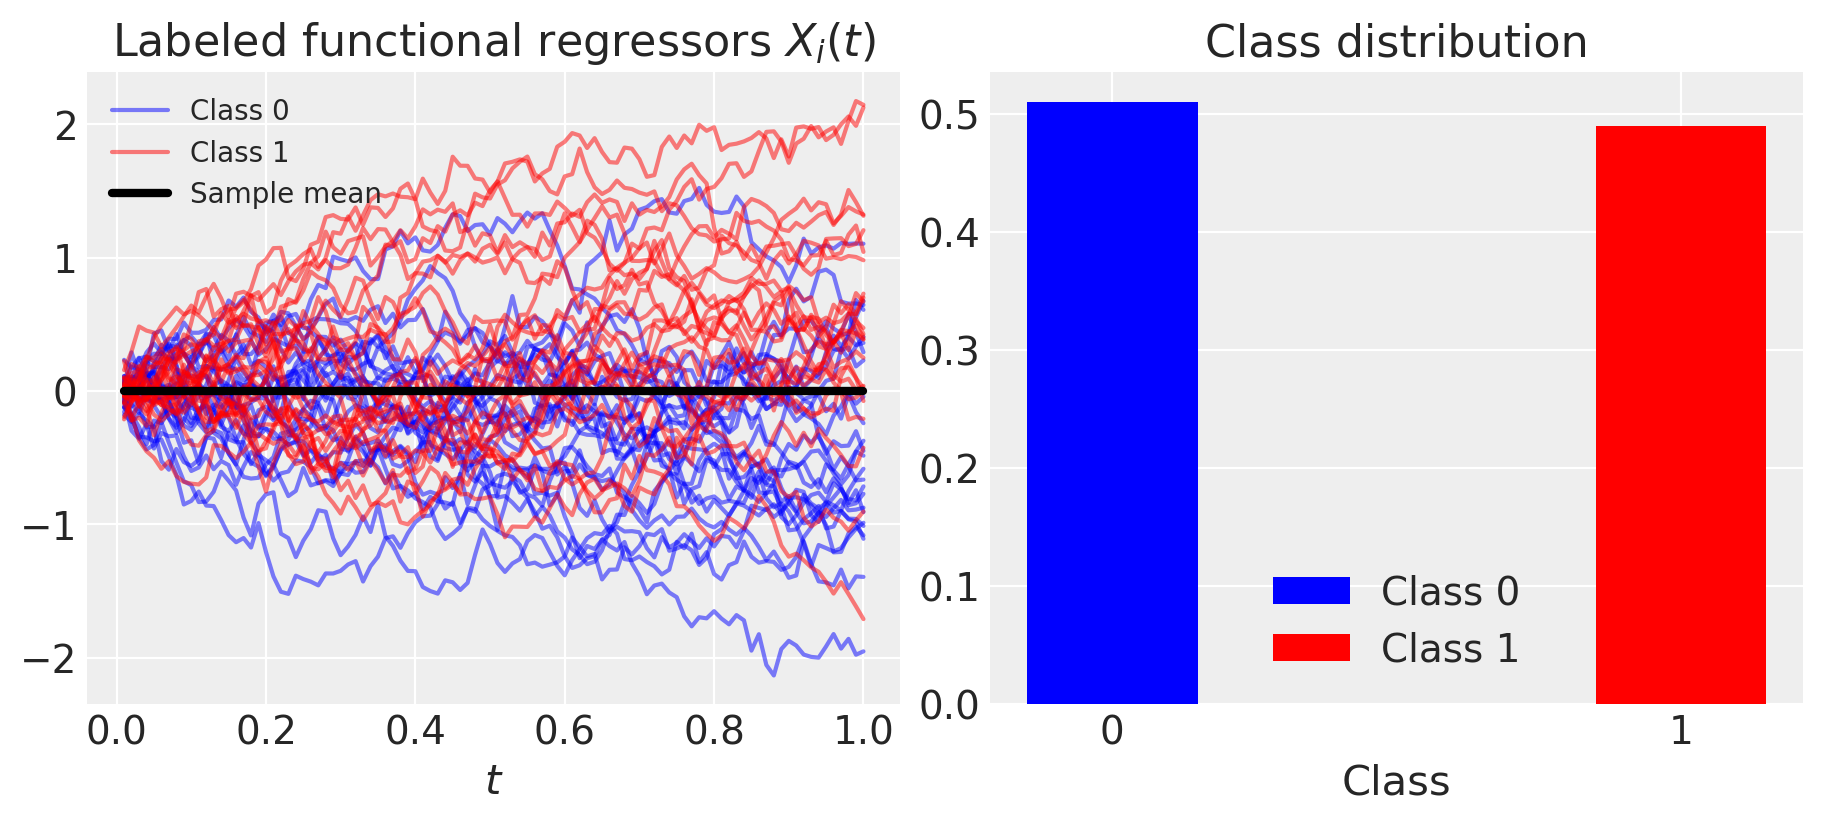

In [7]:
# -- Dataset visualization

if SYNTHETIC_DATA:
    n_samples = n_train//2
elif REAL_DATA == "Medflies":
    n_samples = n_train//5
else:
    n_samples = n_train

plot_utils.plot_dataset_classification(
    X,
    Y,
    n_samples=n_samples
)

## Common model hyperparameters

In our algorithms, we consider an unconstrained tranformed parameter space $\tilde \Theta=\mathbb{R}^{2\hat p+2}$ via the bijections

- $\tau_j \mapsto \operatorname{logit}(\tau_j)$.
- $\sigma^2 \mapsto \log\sigma$.

In [16]:
# -- Model hyperparameters

p_max = 3
g = 5
eta = 0.01

PRIOR_P_MANUAL = False
if PRIOR_P_MANUAL:
    prior_p = {
        1: 0.10,
        2: 0.60,
        3: 0.30,
    }
else:
    lambda_param = 1
    p_range = range(1, p_max + 1)
    p_probs = [stats.poisson.pmf(p, mu=lambda_param, loc=1) for p in p_range]
    p_probs = p_probs/np.sum(p_probs)
    prior_p = {p: x for x, p in zip(p_probs, p_range)}

mle_method = 'L-BFGS-B'  # 'Nelder-Mead', 'Powell' or 'L-BFGS-B'
mle_strategy = 'global'
beta_range = None
sigma2_ub = np.inf
relabel_strategy = 'auto'

INCLUDE_P = False
TRANSFORM_TAU = False
TRANSFORM_SIGMA = True
PRIOR_TAU = None  # 'None' --> uniform, 'auto' --> beta
FIT_SK = False
COMPUTE_MLE = False

In [17]:
# -- Names and labels

# Names of parameters
theta_names = ["β", "τ", "α0", "σ2"]
if INCLUDE_P:
    theta_names = ["p"] + theta_names

# Grouped labels
theta_labels_grouped = [r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]
if INCLUDE_P:
    theta_labels_grouped = [r"$p$"] + theta_labels_grouped

# Individual labels
theta_labels = [] if not INCLUDE_P else [theta_labels_grouped[0]]
for i in range(p_max):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_max):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
dim_name = "theta"
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={dim_name: dict(
        zip(np.arange(p_max), np.arange(1, p_max + 1)))}
)

In [18]:
# -- Parameter space and miscellaneous

if TRANSFORM_TAU:
    tau_ttr = bayesian_model.Logit()
else:
    tau_ttr = bayesian_model.Identity()

if TRANSFORM_SIGMA:
    sigma2_ttr = bayesian_model.LogSq()
else:
    sigma2_ttr = bayesian_model.Identity()

# Parameter space
theta_space = bayesian_model.ThetaSpace(
    p_max,
    grid,
    include_p=INCLUDE_P,
    names=theta_names,
    labels=theta_labels,
    labeller=theta_labeller,
    tau_range=tau_range,
    beta_range=beta_range,
    tau_ttr=tau_ttr,
    sigma2_ttr=sigma2_ttr,
    sigma2_ub=sigma2_ub
)

# Statistics for posterior predictive checks
point_estimators_bpv = [
    ("min", np.min),
    ("max", np.max),
    ("median", np.median),
    ("mean", np.mean),
    ("std", np.std)
]

# Folds for CV
folds = StratifiedKFold(shuffle=True, random_state=SEED)

# Column to order results
sort_by = -1

## Sklearn model comparison

In [19]:
# -- Select family of classifiers

Cs = np.logspace(-4, 4, 20)
n_selected = [5, 10, 15, 20, 25, 50]
n_components = [2, 3, 4, 5, 7, 10, 15, 20]
n_neighbors = [3, 5, 7, 9, 11]

pls_regressors = [
    PLSRegressionWrapper(n_components=p) for p in n_components]

params_clf = {"clf__C": Cs}
params_select = {"selector__p": n_selected}
params_dim_red = {"dim_red__n_components": n_components}
params_var_sel = {"var_sel__n_features_to_select": n_components}
params_flr = {"clf__p": n_components}
params_knn = {"clf__n_neighbors": n_neighbors,
              "clf__weights": ['uniform', 'distance']}
params_depth = {"clf__depth_method": [
    ModifiedBandDepth(), IntegratedDepth()]}
params_base_regressors_pls = {"clf__base_regressor": pls_regressors}

classifiers = run_utils.logistic_regression_comparison_suite(
    params_clf,
    params_base_regressors_pls,
    params_select,
    params_dim_red,
    params_var_sel,
    params_depth,
    params_knn,
    params_flr,
    random_state=SEED,
)

In [20]:
# -- Fit models and show metrics

if FIT_SK:
    df_metrics_sk, clf_cv = run_utils.cv_sk(
        classifiers,
        X_fd,
        Y,
        X_test_fd,
        Y_test,
        folds,
        kind='logistic',
        n_jobs=N_CORES,
        sort_by=sort_by,
        verbose=True,
    )
    display(df_metrics_sk.style.hide(axis="index"))

  Fitting log...
  Fitting lda...
  Fitting qda...
  Fitting manual+log...


 /home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning:Variables are collinear


  Fitting fpca+log...
  Fitting pca+log...
  Fitting pls+log...
  Fitting apls+log...
  Fitting rkvs+log...
  Fitting rmh+log...
  Fitting pca+qda...
  Fitting pls+nc...
  Fitting apls+nc...
  Fitting flog...
  Fitting flda...


 /home/antcc/.micromamba/envs/bfr-py39/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning:The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).


  Fitting mdc...
  Fitting fknn...
  Fitting fnc...


## Maximum Likelihood Estimator

Here is an example of MLE approximation. We can use the MLE as a classifier as well, following our model.

In [21]:
# -- MLE computation

if COMPUTE_MLE:
    print(f"-- Computing MLE with {N_CORES} independent runs --")

    theta_space_fixed = theta_space.copy_p_fixed()

    mle_theta, bic = compute_mle(
        X,
        Y,
        theta_space_fixed,
        kind='logistic',
        method=mle_method,
        strategy=mle_strategy,
        n_jobs=N_CORES,
        rng=rng
    )

    Y_pred_mle = bayesian_model.generate_response_logistic(
        X_test, mle_theta, theta_space_fixed, noise=False
    )

    df_metrics_mle = run_utils.logistic_regression_metrics(
        Y_test,
        Y_pred_mle,
        theta_space.p_max,
        "mle"
    )
    print(f"\nBIC [p={p_max}]: {bic:.3f}")
    display(pd.DataFrame(zip(theta_space_fixed.labels, mle_theta),
                         columns=["", "MLE"]).style.hide(axis="index"))
    print("Classification metrics:")
    display(df_metrics_mle.style.hide(axis="index"))

-- Computing MLE with 4 independent runs --

BIC [p=3]: 120.167


Classification metrics:


## The Ensemble Sampler and the *emcee* library

In [22]:
import emcee
from rkbfr.mcmc_sampler import BFLogisticEmcee

### Experiments

A fast overview of the inference a prediction procedure is shown if `FAST_RUN` is set to True.

In [23]:
# -- Sampler parameters

n_walkers = 32
n_iter_warmup = 100
n_iter = 700

compute_pp = False
compute_ll = False
frac_random = 0.3

moves = [
    (emcee.moves.StretchMove(), 0.7),
    (emcee.moves.WalkMove(), 0.3)
]

thin = 1
thin_pp = 5
burn = 300

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [24]:
# -- Run sampler

print("-- Running affine-invariant ensemble sampler "
      f"with {N_CORES} cores --")

clf_emcee = BFLogisticEmcee(
    theta_space,
    n_walkers,
    n_iter,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    prior_tau=PRIOR_TAU,
    n_iter_warmup=n_iter_warmup,
    initial_state='mle',
    frac_random=frac_random,
    relabel_strategy=relabel_strategy,
    moves=moves,
    compute_pp=compute_pp,
    compute_ll=compute_ll,
    thin=thin,
    thin_pp=thin_pp,
    burn=burn,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    progress_notebook=True,
    random_state=rng,  # change to 'SEED' for the same output each time
)

if FAST_RUN:
    df_metrics_emcee = run_utils.run_bayesian_model(
        clf_emcee,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        kind='logistic',
        prefix='emcee',
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        verbose=True,
        notebook=True,
        sort_by=sort_by,
        random_state=SEED,
    )
    if COMPUTE_METRICS_FAST_RUN:
        if COMPUTE_MLE:
            df_metrics_emcee = pd.concat([df_metrics_emcee, df_metrics_mle])
        if FIT_SK:
            df_metrics_emcee = pd.concat([df_metrics_emcee, df_metrics_sk])

        df_metrics_emcee.sort_values(
            df_metrics_emcee.columns[sort_by],
            inplace=True,
            ascending=False
        )
        display(df_metrics_emcee.style.hide(axis="index"))
else:
    clf_emcee.fit(X, Y)
    print(f"Mean acceptance: {100*clf_emcee.mean_acceptance():.3f}%")

idata_emcee = clf_emcee.get_idata()

-- Running affine-invariant ensemble sampler with 4 cores --
[BFLogisticEmcee] Computing MLE...
[BFLogisticEmcee] MCMC warmup iterations...


[BFLogisticEmcee] MCMC:   0%|          | 0/700 [00:00<?, ?it/s]

[BFLogisticEmcee] Discarding the first 300 samples...
Mean acceptance: 12.522%


mean      sd  hdi_3%  hdi_97%     min      max  median   mode
β[1]        -1.718   1.734  -3.631    0.280 -10.026    0.822  -1.432 -2.028
β[2]         1.028   0.899  -0.541    2.997  -1.858    3.760   0.967  0.880
β[3]         3.329   1.851   1.535    5.000   1.120   13.012   2.987  2.990
τ[1]         0.610   0.312   0.051    1.000   0.001    1.000   0.612  0.999
τ[2]         0.503   0.292   0.087    0.930   0.005    0.998   0.445  0.188
τ[3]         0.822   0.081   0.760    0.891   0.060    0.940   0.824  0.809
$\alpha_0$  -0.102   0.280  -0.637    0.398  -0.965    0.950  -0.057  0.013
$\sigma^2$  10.937  19.126   0.073   48.654   0.038  146.218   3.879  0.180


Computing metrics...

Generating posterior predictive samples...
Generating posterior predictive samples...


### Analysis

The effective sample size is computed as suggested [here (p.66)](https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/mcmc_slides.pdf) (missing values are replaced with a value of $0$).

In [25]:
# -- Sampler statistics and trace (with burn-in and thinning)

# Get number of samples
n_samples_emcee = clf_emcee.total_samples()

# Get autocorrelation times
autocorr = clf_emcee.autocorrelation_times()

pd.DataFrame(
    zip(theta_labels, autocorr, n_samples_emcee/autocorr),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide(axis="index")

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [33.775 39.877 33.092 37.95  37.675 31.914 39.7   37.472]


In [26]:
# -- Trace summary

clf_emcee.summary()

mean      sd  hdi_3%  hdi_97%     min      max  median   mode
β[1]        -1.718   1.734  -3.631    0.280 -10.026    0.822  -1.432 -2.028
β[2]         1.028   0.899  -0.541    2.997  -1.858    3.760   0.967  0.880
β[3]         3.329   1.851   1.535    5.000   1.120   13.012   2.987  2.990
τ[1]         0.610   0.312   0.051    1.000   0.001    1.000   0.612  0.999
τ[2]         0.503   0.292   0.087    0.930   0.005    0.998   0.445  0.188
τ[3]         0.822   0.081   0.760    0.891   0.060    0.940   0.824  0.809
$\alpha_0$  -0.102   0.280  -0.637    0.398  -0.965    0.950  -0.057  0.013
$\sigma^2$  10.937  19.126   0.073   48.654   0.038  146.218   3.879  0.180

Combined density and trace plot:


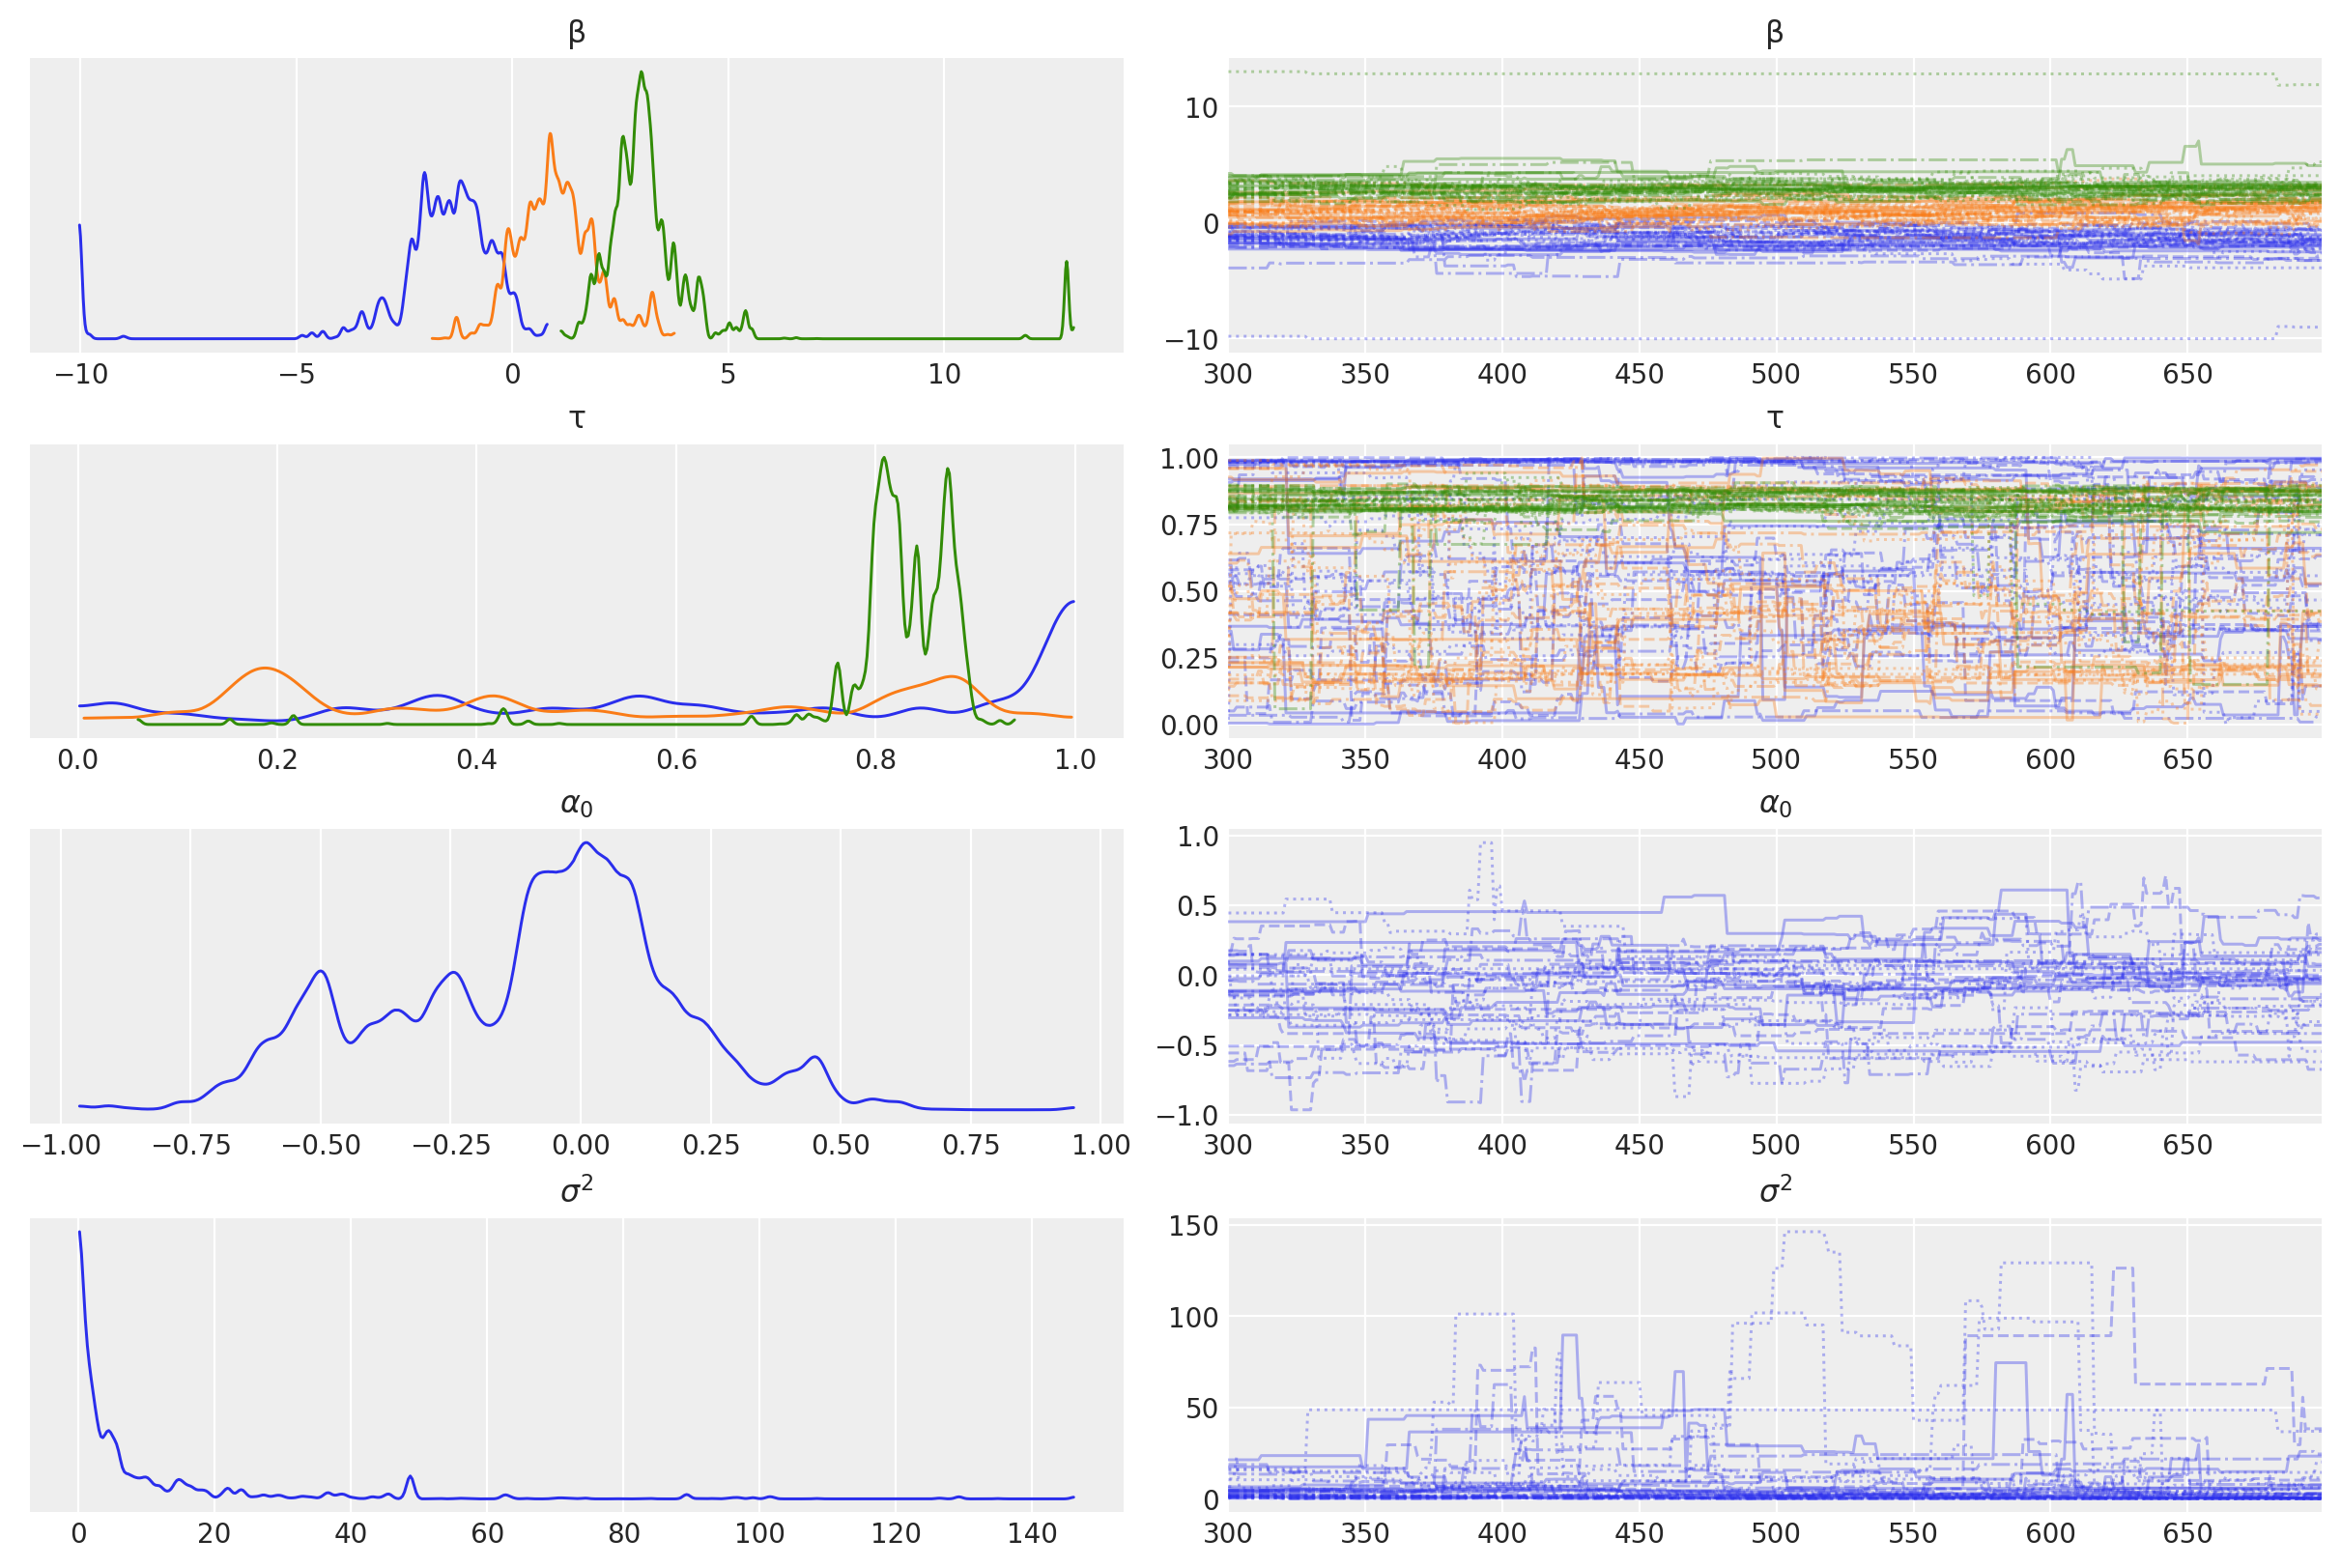

In [27]:
# -- Trace plot

az.plot_trace(
    idata_emcee,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)

print("Combined density and trace plot:")

Marginal posterior distributions:


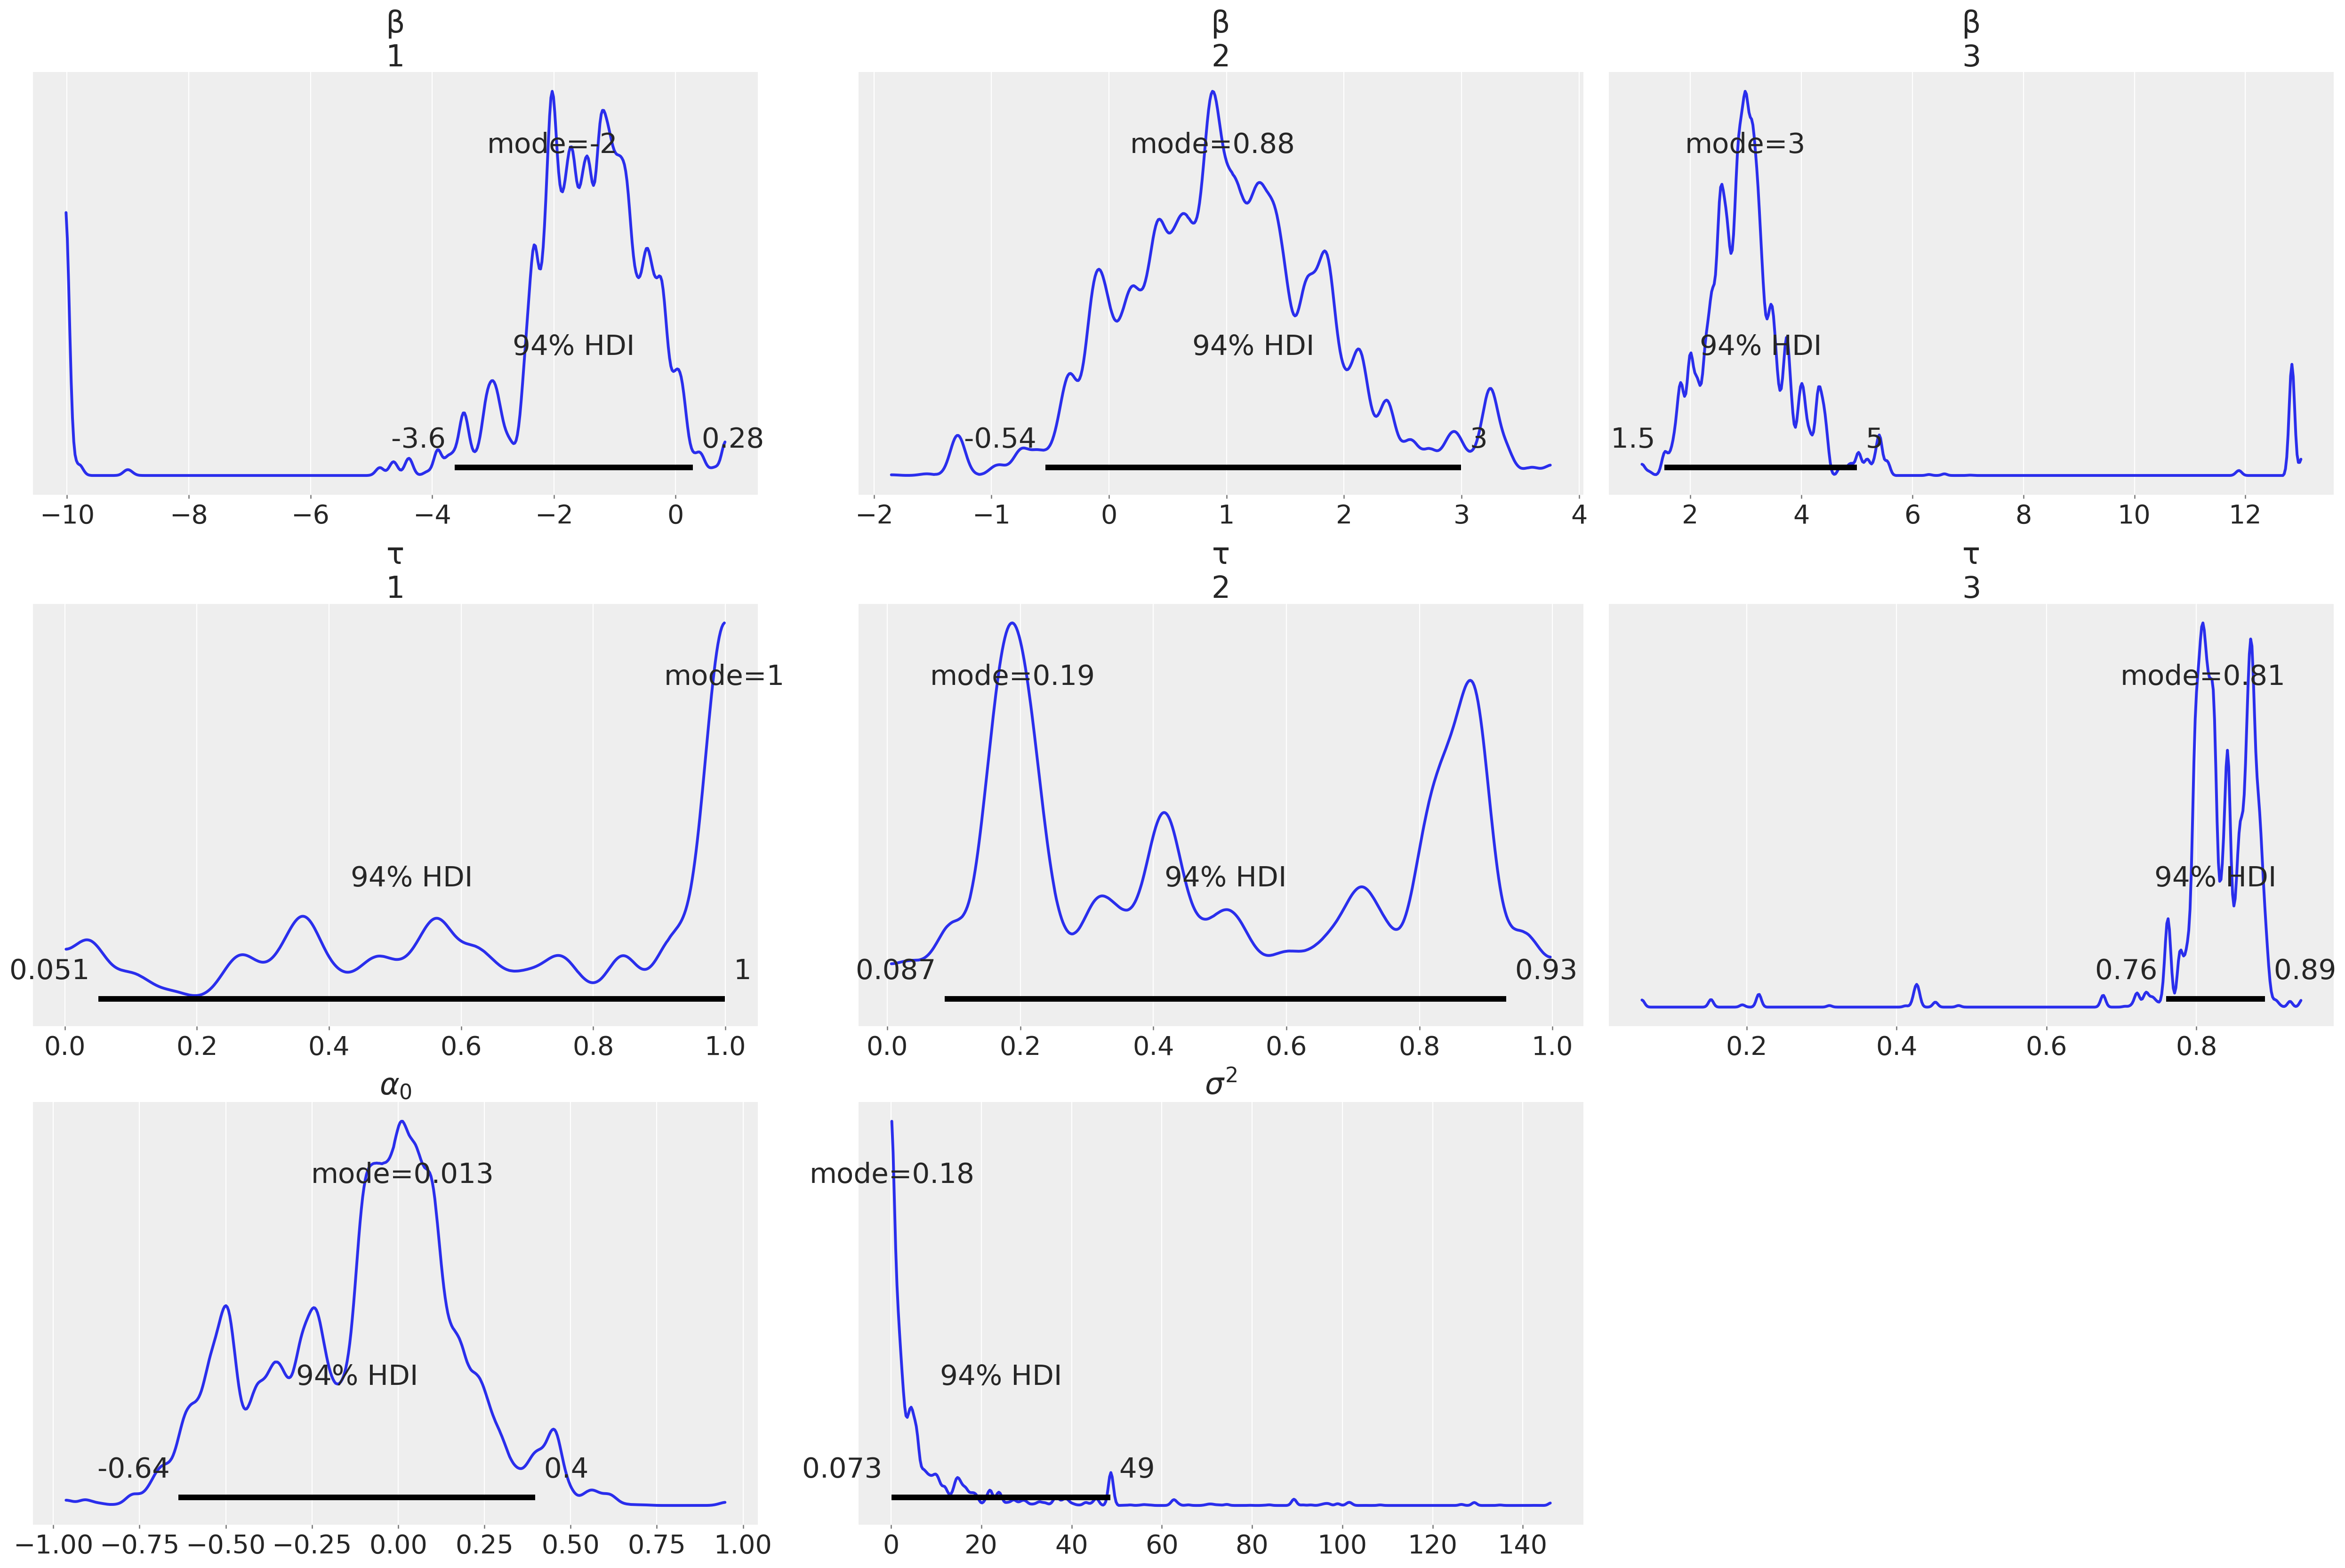

In [28]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

Forest plot of 94% HDI for β and τ:


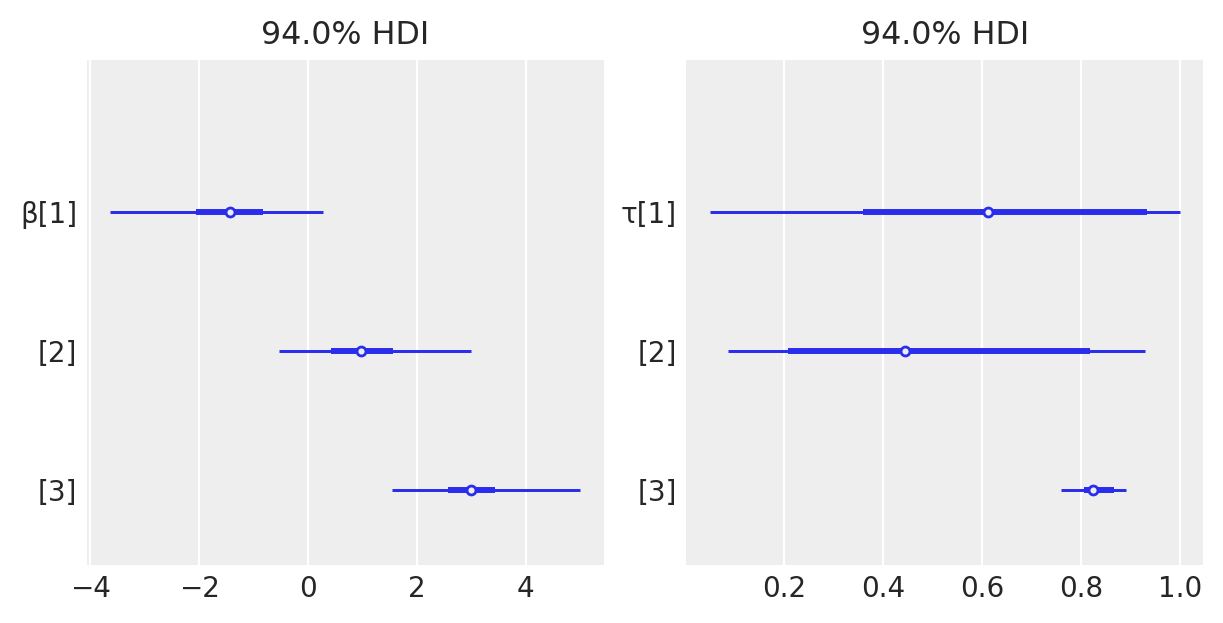

In [29]:
# -- Forest plot

plot_utils.plot_forest(
    idata_emcee,
    theta_space,
    textsize=10,
    var_names=[theta_names[theta_space.beta_idx_grouped],
               theta_names[theta_space.tau_idx_grouped]]
)

print("Forest plot of 94% HDI for β and τ:")

In this case, since the outcome variable is binary, we plot the distribution of $T(Y^*)$ to visually compare it with $T(Y)$, where $T$ is the number of $1$s in the sample (the number of successes). 

We also show a *separation plot*, in which the predicted probabilities $\hat p_i$ (suitably averaged for each chain and sample) are ordered in an ascending manner, and then a vertical line is drawn on each of them either in a dark color (if $y_i$ is 1) or a light color (if $y_i$ is 0). In a perfect model, all the dark lines would be on the rightmost part, effectively "separating" the samples.

Generating posterior predictive samples...
bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.546
bpv [T=mean]: 0.546
bpv [T=std]: 0.918


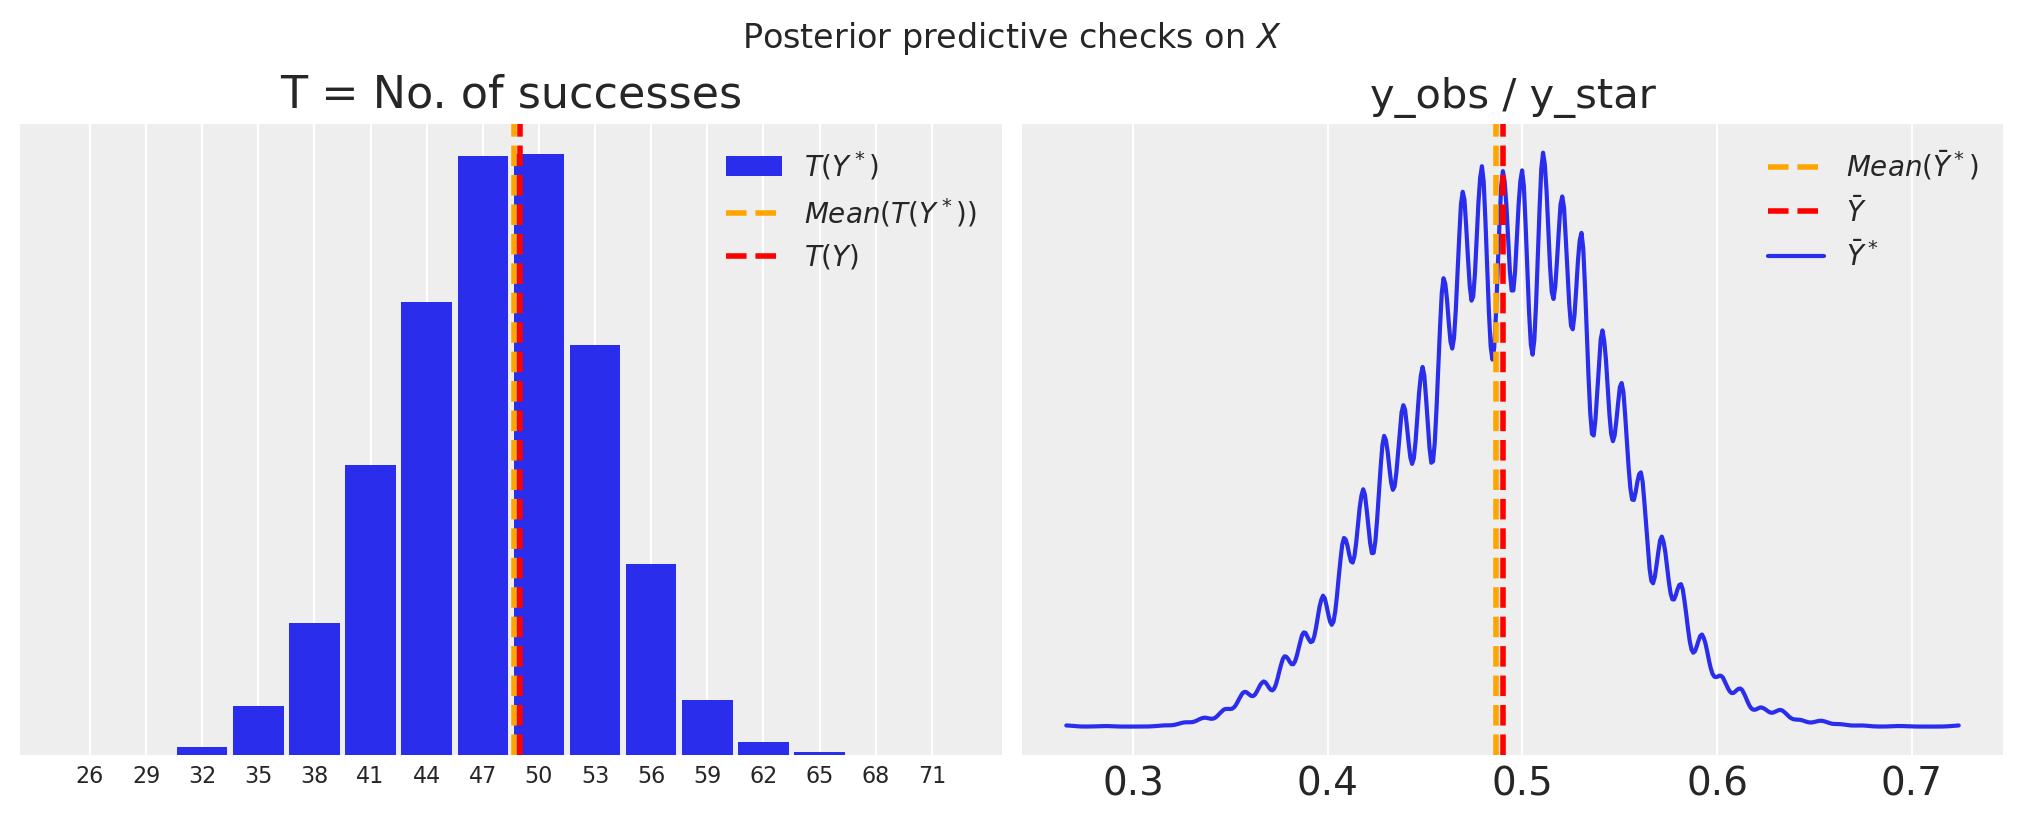

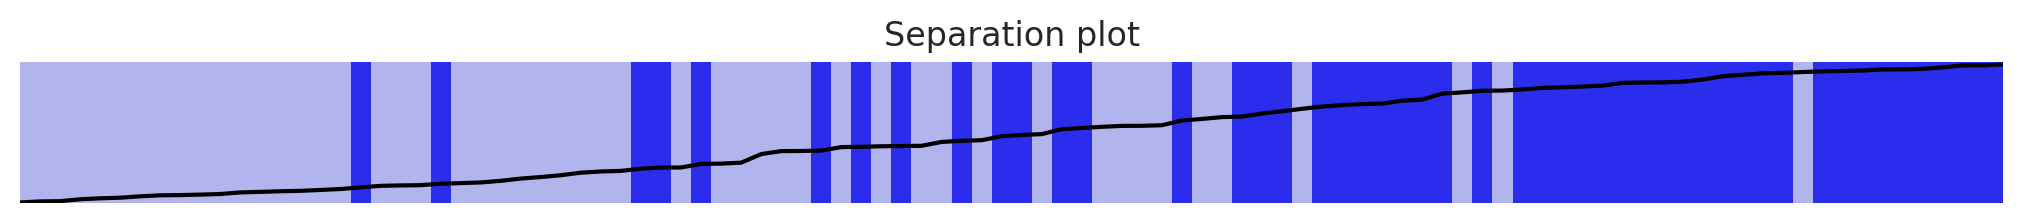

In [30]:
# -- Generate and plot posterior predictive checks from X

if "posterior_predictive" not in idata_emcee:
    pp_p, pp_y = bayesian_model.generate_pp(
        idata_emcee, X, theta_space,
        kind='logistic', rng=rng, verbose=True)
    pp_to_idata([pp_p, pp_y], idata_emcee,
                ["p_star", "y_star"], merge=True)
else:
    pp_p = idata_emcee.posterior_predictive['p_star'].to_numpy()
    pp_y = idata_emcee.posterior_predictive['y_star'].to_numpy().astype(int)

# Plot posterior predictive checks
plot_utils.plot_checks_logistic(idata_emcee, test=False)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_y, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


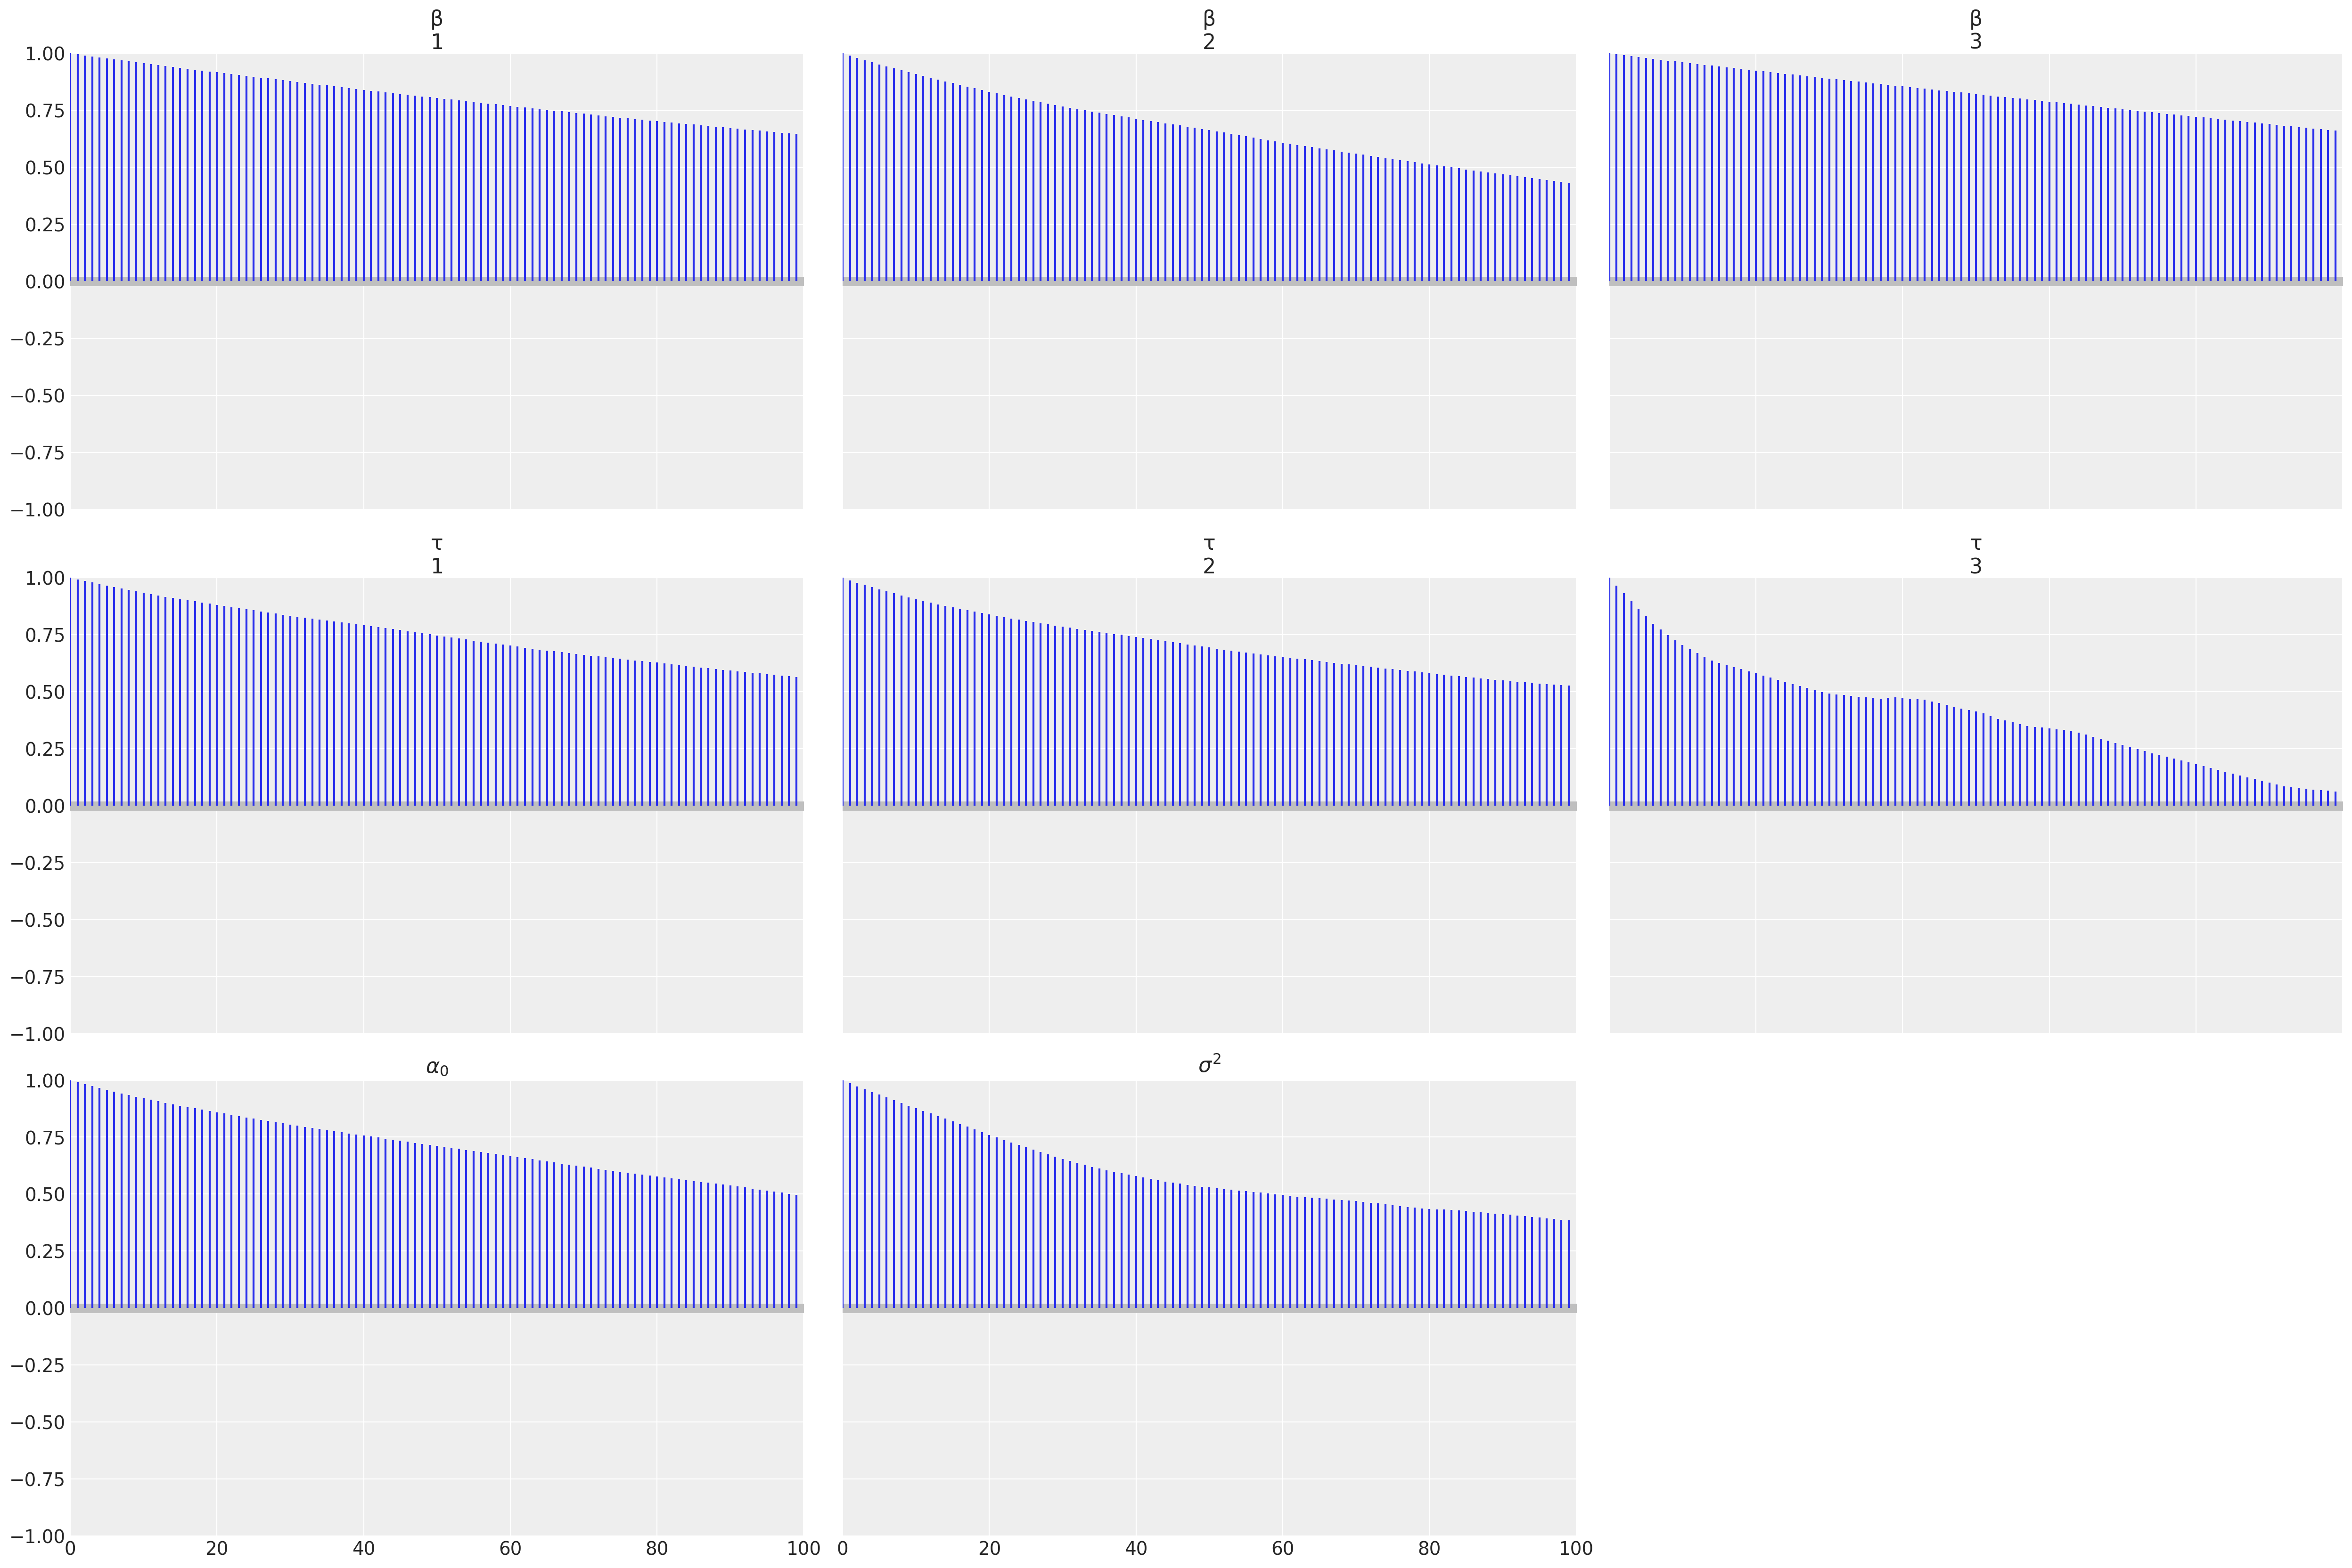

In [31]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

### Out-of-sample predictions

First we take a look at the posterior predictive distribution on a previously unseen dataset.

Generating posterior predictive samples...
bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.455
bpv [T=mean]: 0.455
bpv [T=std]: 0.833


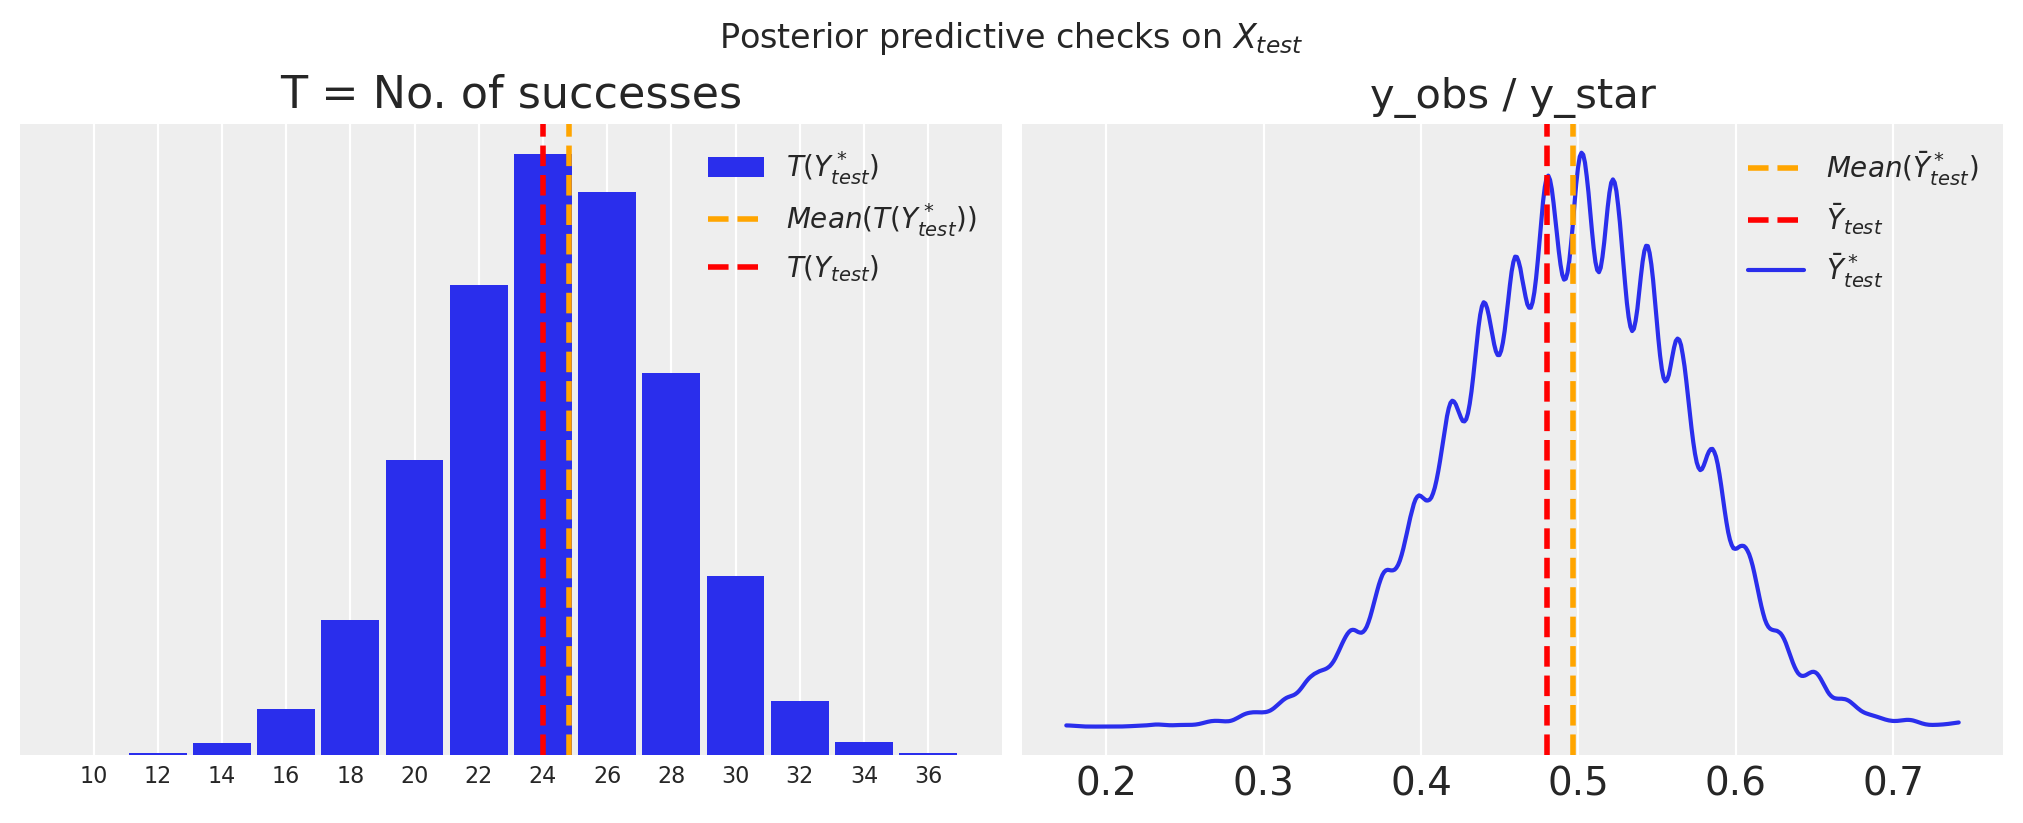

In [32]:
# -- Generate and plot posterior predictive samples from X_test

pp_test_p, pp_test_y = bayesian_model.generate_pp(
    idata_emcee, X_test, theta_space,
    rng=rng, kind='logistic', verbose=True)
idata_pp_test = pp_to_idata(
    [pp_test_p, pp_test_y], idata_emcee, ["p_star", "y_star"], y_obs=Y_test)

# Plot posterior predictive checks
plot_utils.plot_checks_logistic(idata_pp_test, test=True)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test_y, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Next we look at the accuracy when using several point-estimates for the parameters, as well as the mean of the posterior samples.

In [33]:
# -- Compute metrics using several point estimates

df_metrics_emcee = None

# Posterior mean estimates
strategies = [("posterior_mean", pp_test_p), ("posterior_vote", pp_test_y)]
for name, pp in strategies:
    Y_pred_pp = [apply_threshold(y)
                 for y in pp[:, ::thin_pp, :].mean(axis=(0, 1))]
    df_metrics_emcee = run_utils.logistic_regression_metrics(
        Y_test,
        Y_pred_pp,
        clf_emcee.n_components(name),
        "emcee_" + name,
        df=df_metrics_emcee,
        sort_by=sort_by
    )

# Point estimates
for pe in clf_emcee.default_point_estimates:
    Y_pred_pe = clf_emcee.predict(X_test, strategy=pe)
    df_metrics_emcee = run_utils.logistic_regression_metrics(
        Y_test,
        Y_pred_pe,
        clf_emcee.n_components(pe),
        "emcee_" + pe,
        df=df_metrics_emcee,
        sort_by=sort_by,
    )

df_metrics_emcee.style.hide(axis="index")

In [34]:
# -- Test variable selection procedure

df_metrics_emcee_var_sel = None

for pe in clf_emcee.default_point_estimates:
    X_red = clf_emcee.transform(X, pe=pe)
    X_test_red = clf_emcee.transform(X_test, pe=pe)

    df_metrics_emcee_var_sel = run_utils.multiple_logistic_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="emcee",
        pe=pe,
        df=df_metrics_emcee_var_sel,
        random_state=SEED
    )

df_metrics_emcee_var_sel.style.hide(axis="index")

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [ ]:
# -- Save

with open("emcee-logistic.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [ ]:
# -- Load

with open("emcee-logistic.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

In [57]:
from rkbfr.mcmc_sampler import BFLogisticPymc
import pymc as pm

### Experiments

In [58]:
# -- Sampler parameters

n_chains = N_CORES
USE_NUTS = False

if USE_NUTS:
    n_samples = 500
    n_tune = 500
    step_fn = pm.NUTS
    step_kwargs = {"target_accept": 0.8}
else:
    n_samples = 5000
    n_tune = 5000
    step_fn = pm.Metropolis
    step_kwargs = {}

burn = 0
thin = 1
thin_pp = 5

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [59]:
# -- Run sampler

print(f"-- Running pymc sampler with {N_CORES} cores --")

clf_pymc = BFLogisticPymc(
    theta_space,
    n_chains,
    n_samples,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    prior_tau=PRIOR_TAU,
    step_fn=step_fn,
    step_kwargs=step_kwargs,
    n_iter_warmup=n_tune,
    relabel_strategy=relabel_strategy,
    thin=thin,
    thin_pp=thin_pp,
    burn=burn,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    random_state=rng  # change to 'SEED' for the same output each time
)

if FAST_RUN:
    df_metrics_pymc = run_utils.run_bayesian_model(
        clf_pymc,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        kind='logistic',
        prefix='pymc',
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        verbose=True,
        notebook=True,
        sort_by=sort_by,
        random_state=SEED,
    )
    if COMPUTE_METRICS_FAST_RUN:
        if COMPUTE_MLE:
            df_metrics_pymc = pd.concat([df_metrics_pymc, df_metrics_mle])
        if FIT_SK:
            df_metrics_pymc = pd.concat([df_metrics_pymc, df_metrics_sk])

        df_metrics_pymc.sort_values(
            df_metrics_pymc.columns[sort_by],
            inplace=True,
            ascending=False
        )
        display(df_metrics_pymc.style.hide(axis="index"))
else:
    clf_pymc.fit(X, Y)
    print(f"Mean acceptance: {100*reg_pymc.mean_acceptance():.3f}%")

idata_pymc = clf_pymc.get_idata()

-- Running pymc sampler with 4 cores --
[BFLogisticPymc] Computing MLE...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [α0_and_LogSq σ2]
>Metropolis: [τ_unordered]
>Metropolis: [β_unbounded]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 84 seconds.


[BFLogisticPymc] Discarding the first 0 samples...
Mean acceptance: 38.261%


mean       sd  hdi_3%  hdi_97%     min        max  median  \
β[1]         1.661    1.805  -2.083    4.288 -10.690      6.927   2.356   
β[2]         3.972    1.632   0.006    6.284  -4.521      9.604   4.608   
β[3]        -3.438    2.260  -5.699    2.388  -8.618      6.274  -4.470   
τ[1]         0.727    0.230   0.121    0.895   0.000      0.949   0.820   
τ[2]         0.898    0.095   0.795    0.992   0.091      0.999   0.916   
τ[3]         0.952    0.050   0.845    1.000   0.726      1.000   0.977   
$\alpha_0$  -0.082    0.265  -0.596    0.397  -1.070      0.862  -0.081   
$\sigma^2$  41.552  220.480   0.000  135.080   0.000  10960.550   1.769   

              mode  
β[1]         2.437  
β[2]         4.735  
β[3]        -5.026  
τ[1]         0.819  
τ[2]         0.968  
τ[3]         0.981  
$\alpha_0$  -0.012  
$\sigma^2$  10.704


Computing metrics...

Generating posterior predictive samples...
Generating posterior predictive samples...


### Analysis

In [60]:
# -- Trace summary

clf_pymc.summary(stats='all')

mean       sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β[1]         1.661    1.805  -2.083    4.288      0.502    0.363      15.0   
β[2]         3.972    1.632   0.006    6.284      0.377    0.271      33.0   
β[3]        -3.438    2.260  -5.699    2.388      0.765    0.586       9.0   
τ[1]         0.727    0.230   0.121    0.895      0.064    0.049      14.0   
τ[2]         0.898    0.095   0.795    0.992      0.024    0.019      12.0   
τ[3]         0.952    0.050   0.845    1.000      0.008    0.005     111.0   
$\alpha_0$  -0.082    0.265  -0.596    0.397      0.004    0.003    3976.0   
$\sigma^2$  41.552  220.480   0.000  135.080     19.816   14.045       9.0   

            ess_tail  r_hat     min        max  median    mode  
β[1]            90.0   1.29 -10.690      6.927   2.356   2.437  
β[2]            86.0   1.24  -4.521      9.604   4.608   4.735  
β[3]            75.0   1.39  -8.618      6.274  -4.470  -5.026  
τ[1]            57.0   1.20   0.000      0.949   0.820   0.819  
τ[2]            68.0   1.26   0.091      0.999   0.916   0.968  
τ[3]            74.0   1.08   0.726      1.000   0.977   0.981  
$\alpha_0$    4104.0   1.00  -1.070      0.862  -0.081  -0.012  
$\sigma^2$      70.0   1.37   0.000  10960.550   1.769  10.704

Combined density and trace plot:


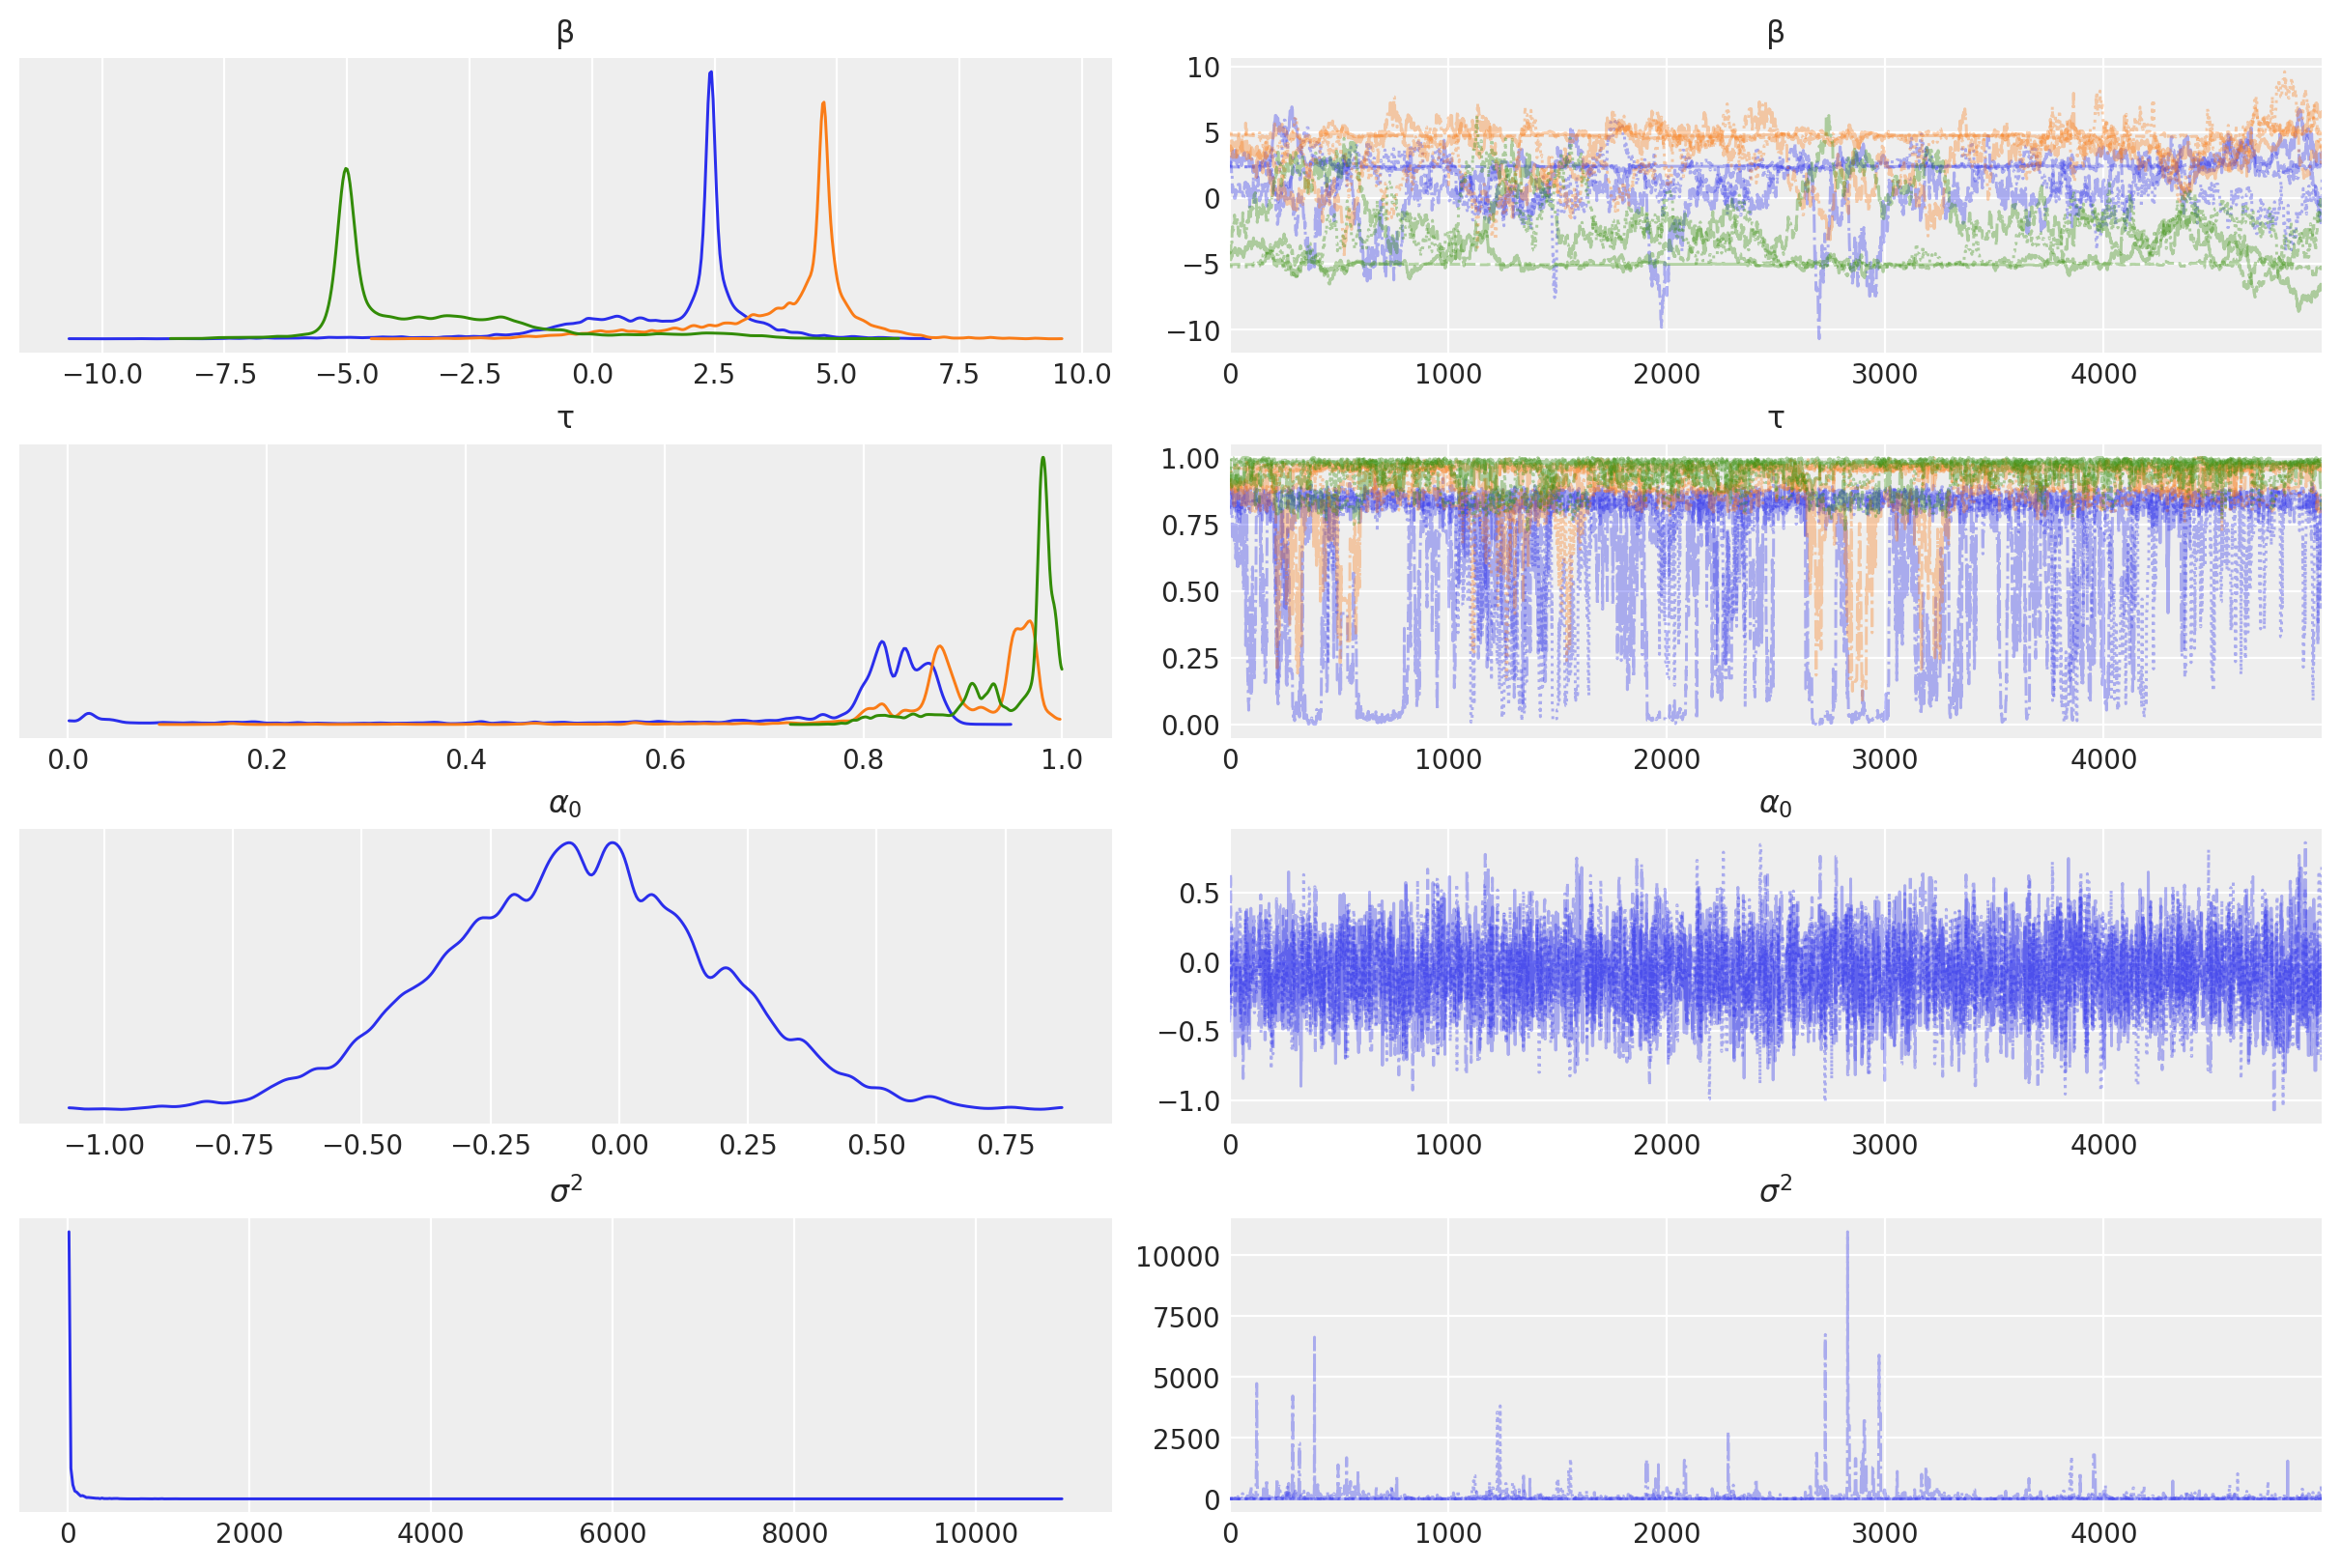

In [61]:
# -- Trace plot

az.plot_trace(
    idata_pymc,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)
print("Combined density and trace plot:")

In [62]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_pymc,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

Marginal posterior distributions:


Forest plot of 94% HDI for β and τ:


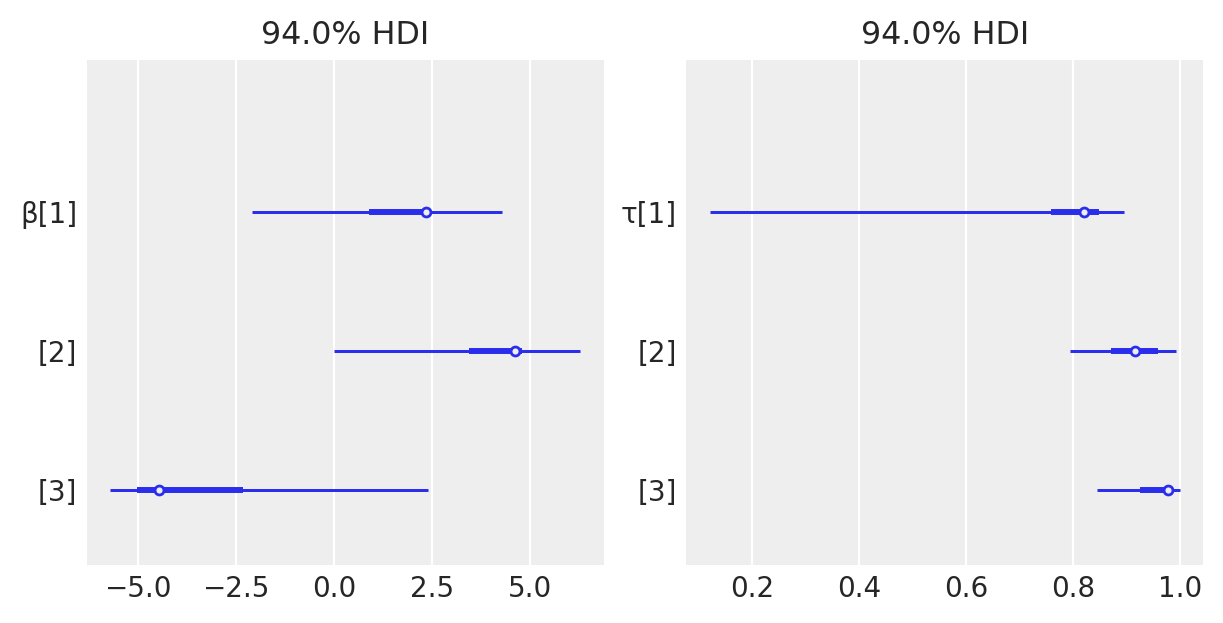

In [63]:
# -- Forest plot

plot_utils.plot_forest(
    idata_pymc,
    theta_space,
    textsize=10,
    var_names=[theta_names[theta_space.beta_idx_grouped],
               theta_names[theta_space.tau_idx_grouped]]
)

print("Forest plot of 94% HDI for β and τ:")

Generating posterior predictive samples...
bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.533
bpv [T=mean]: 0.533
bpv [T=std]: 0.922


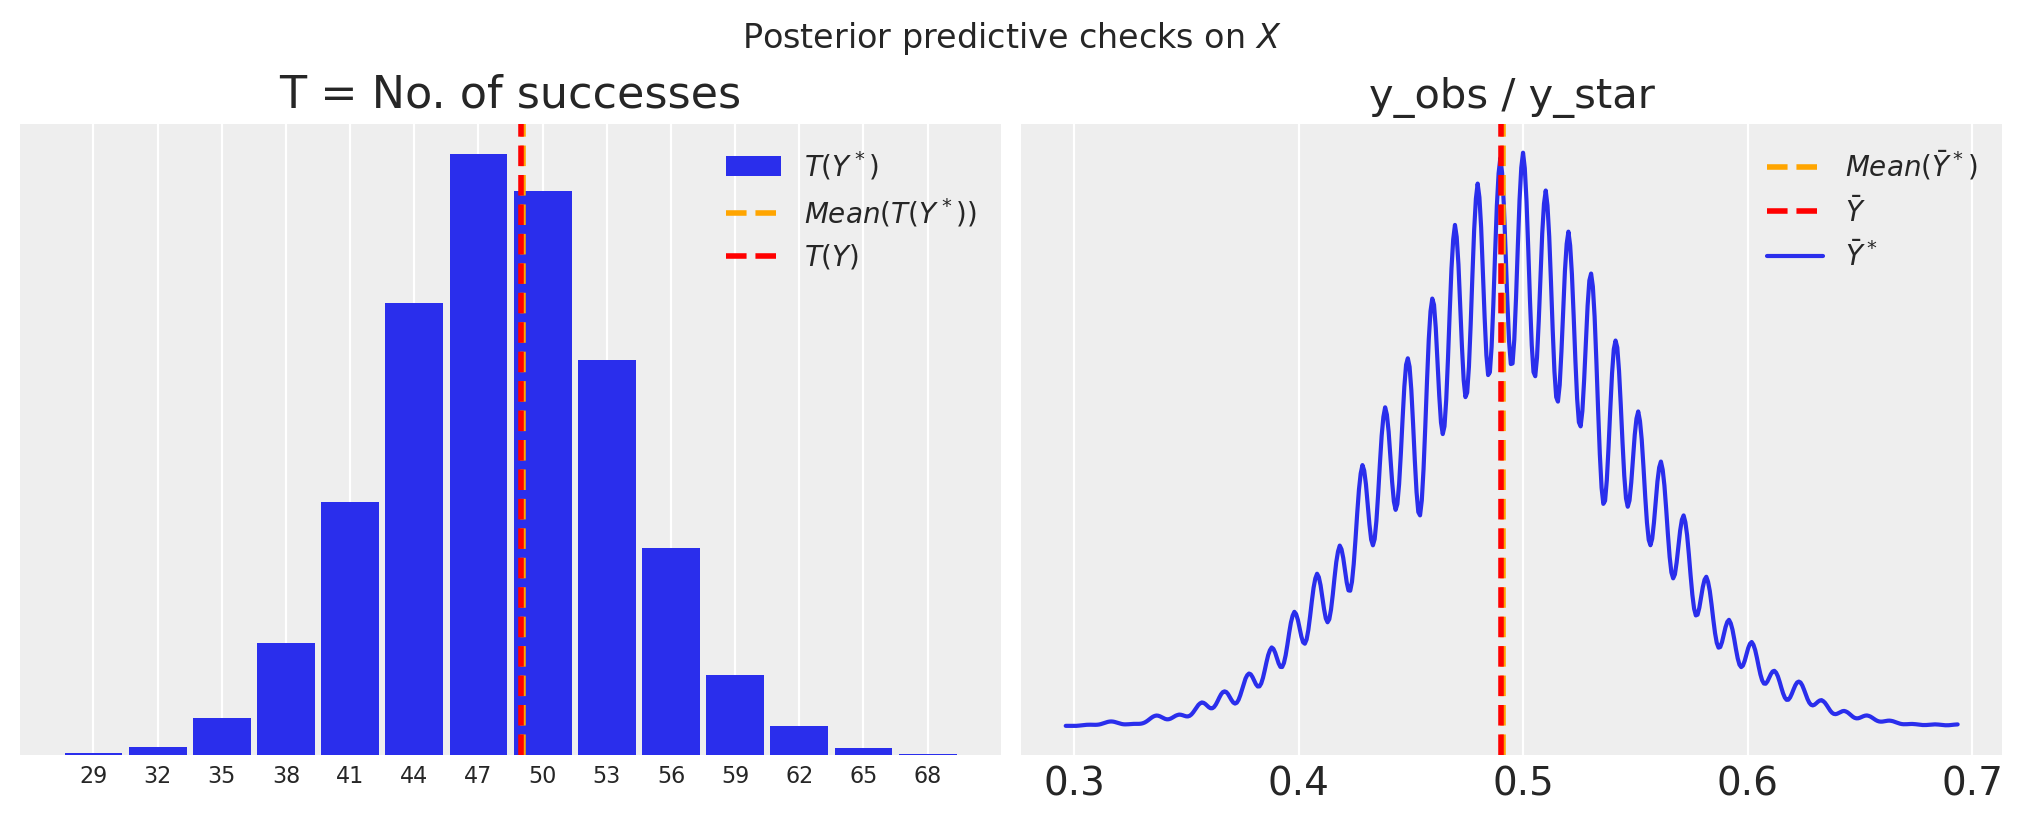

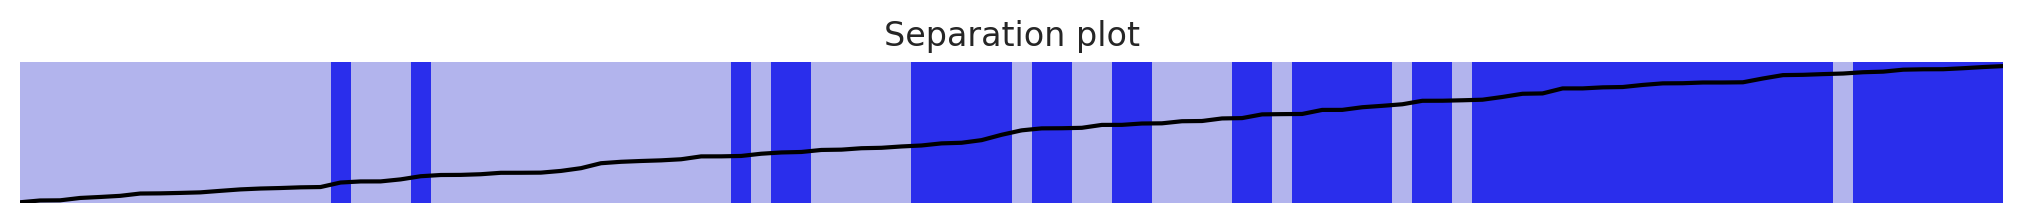

In [64]:
# -- Generate and plot posterior predictive samples from X

pp_p, pp_y = bayesian_model.generate_pp(
    idata_pymc, X, theta_space,
    rng=rng, kind='logistic', verbose=True)
pp_to_idata(
    [pp_p, pp_y], idata_pymc, ['p_star', 'y_star'], merge=True)

# Plot posterior predictive checks
plot_utils.plot_checks_logistic(idata_pymc, test=False)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_y, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


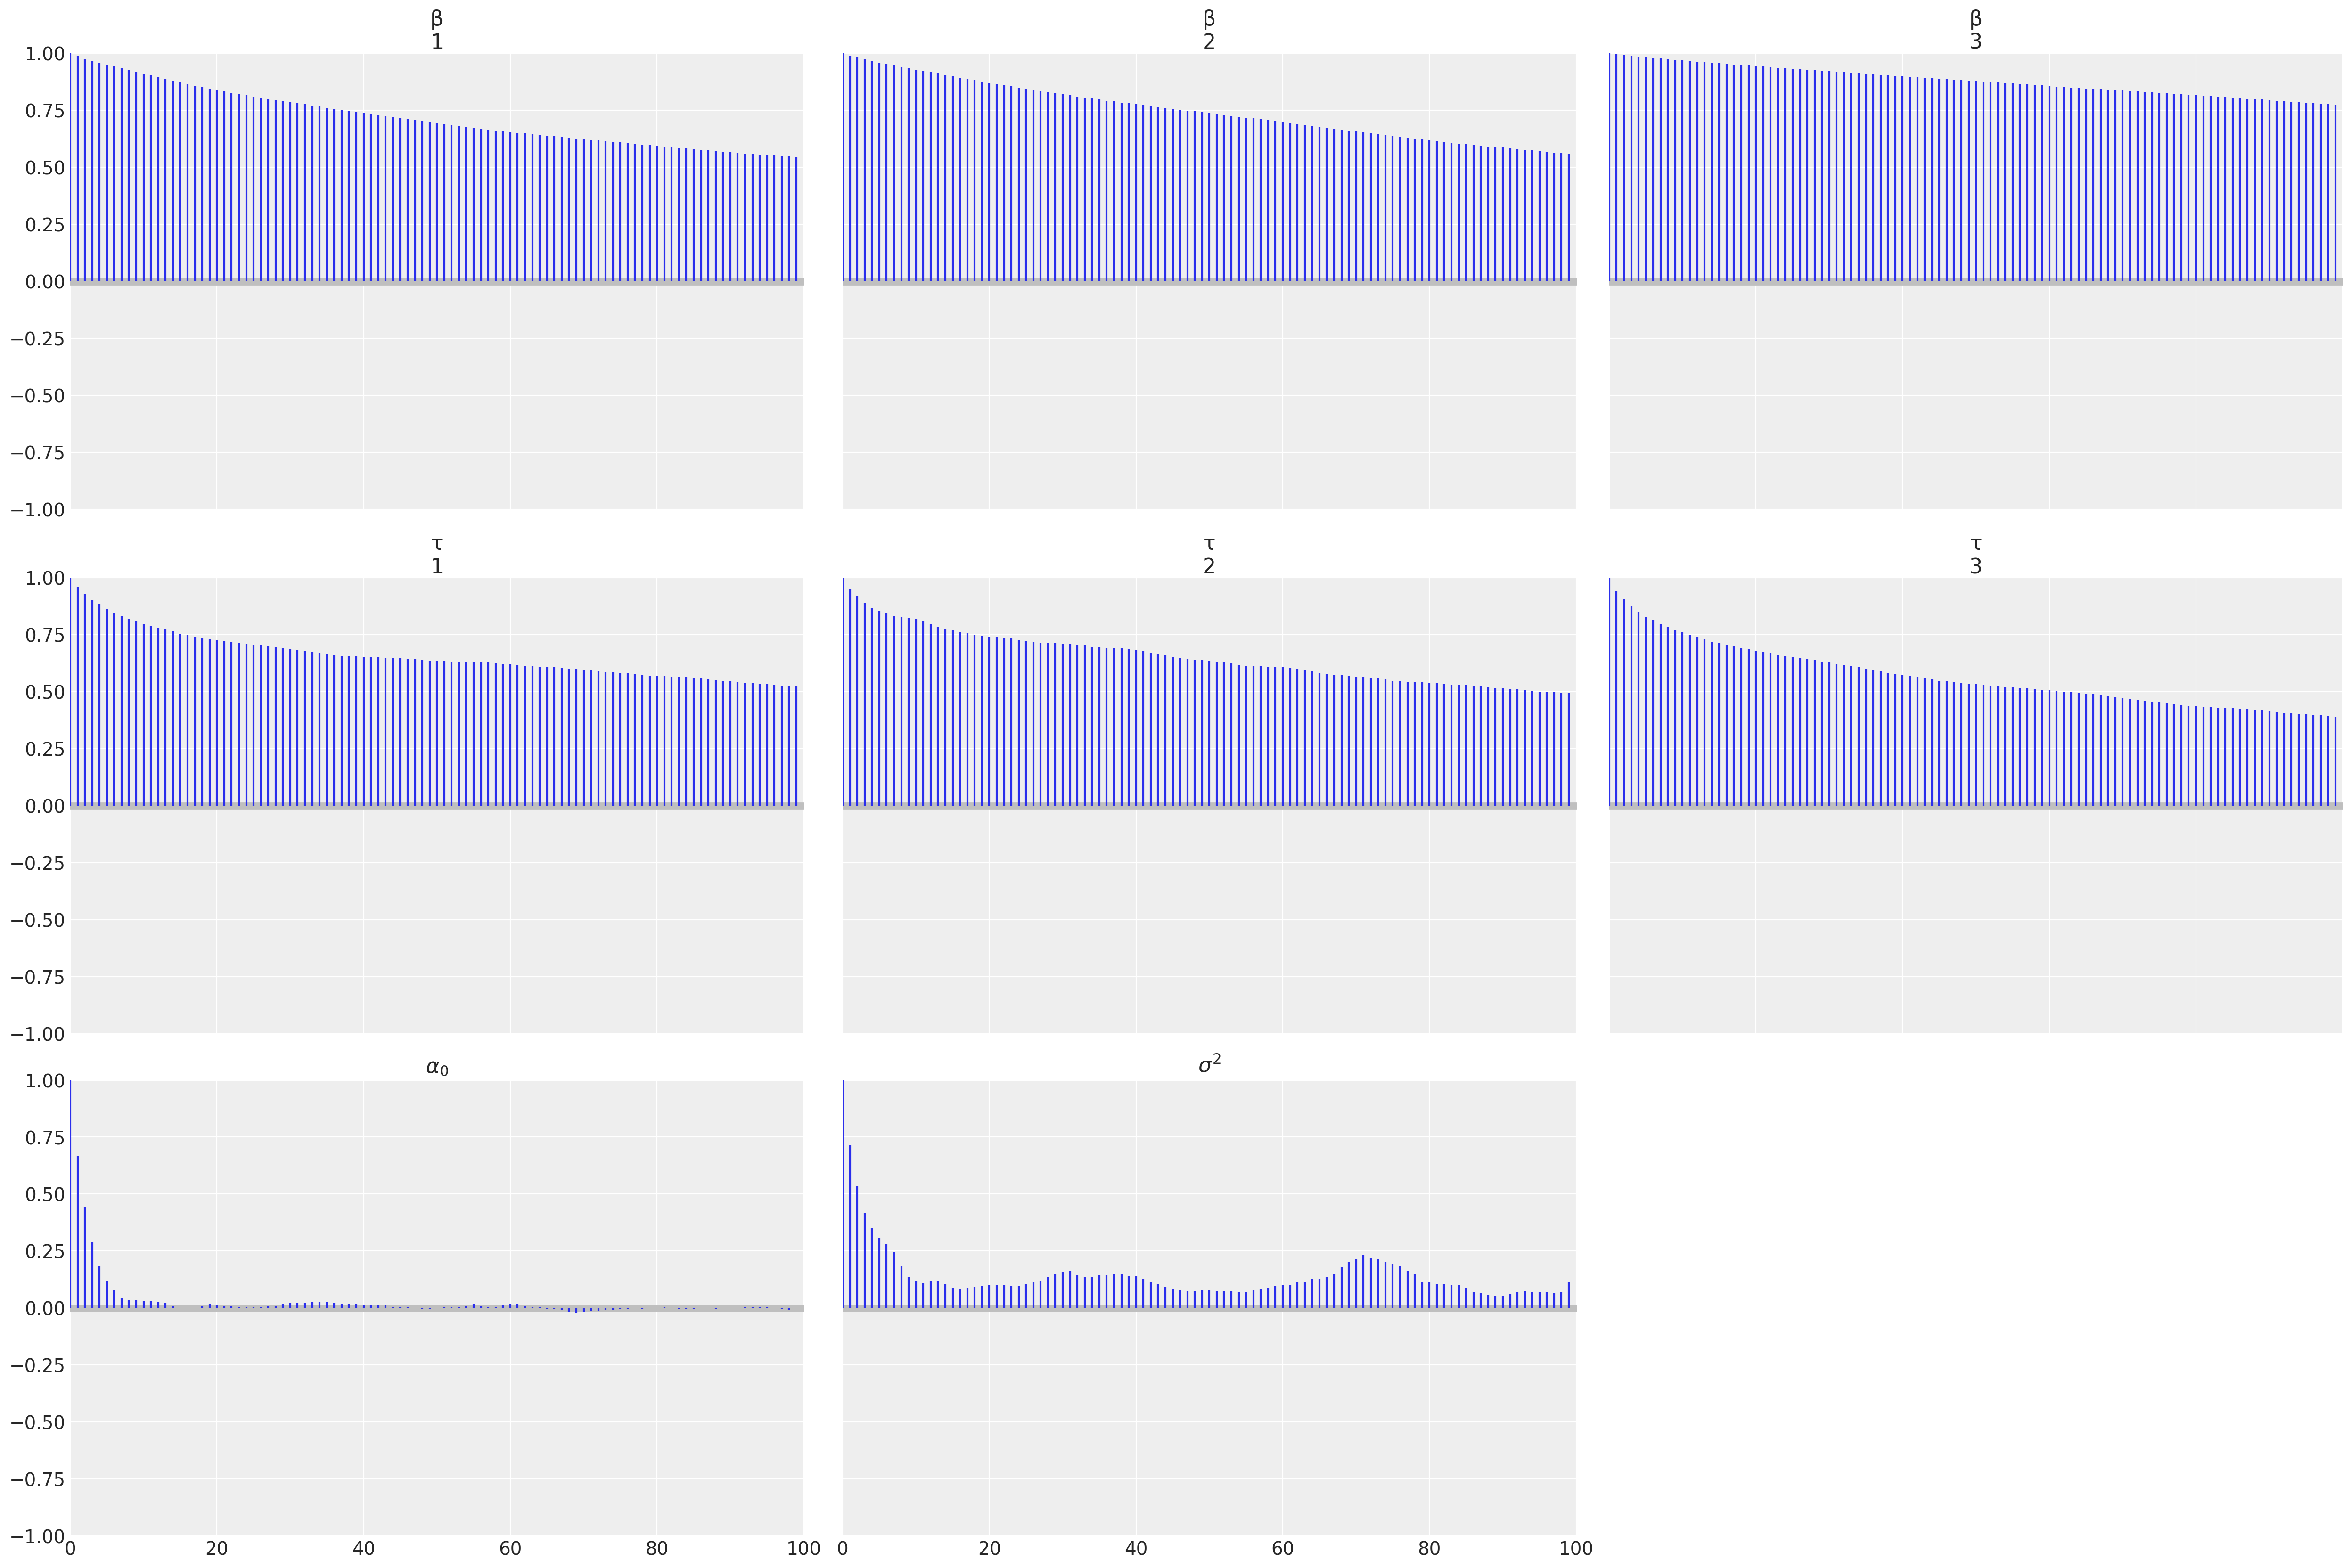

In [65]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_pymc,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

Graphical model:


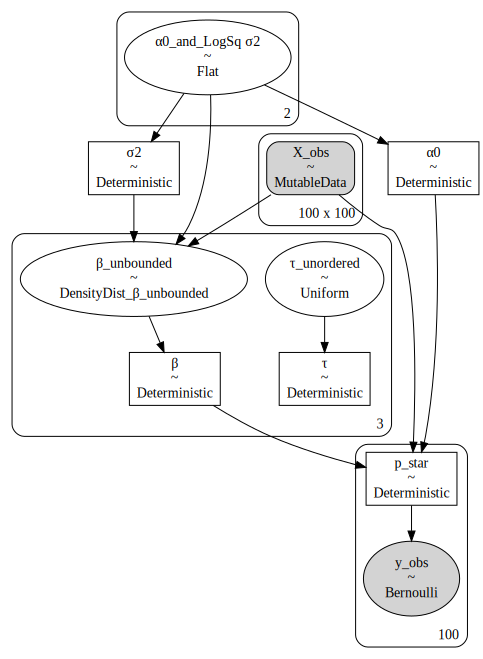

In [66]:
# -- Graphical model

print("Graphical model:")
clf_pymc.to_graphviz()

### Out-of-sample predictions

Generating posterior predictive samples...
bpv [T=min]: 1.000
bpv [T=max]: 1.000
bpv [T=median]: 0.420
bpv [T=mean]: 0.420
bpv [T=std]: 0.833


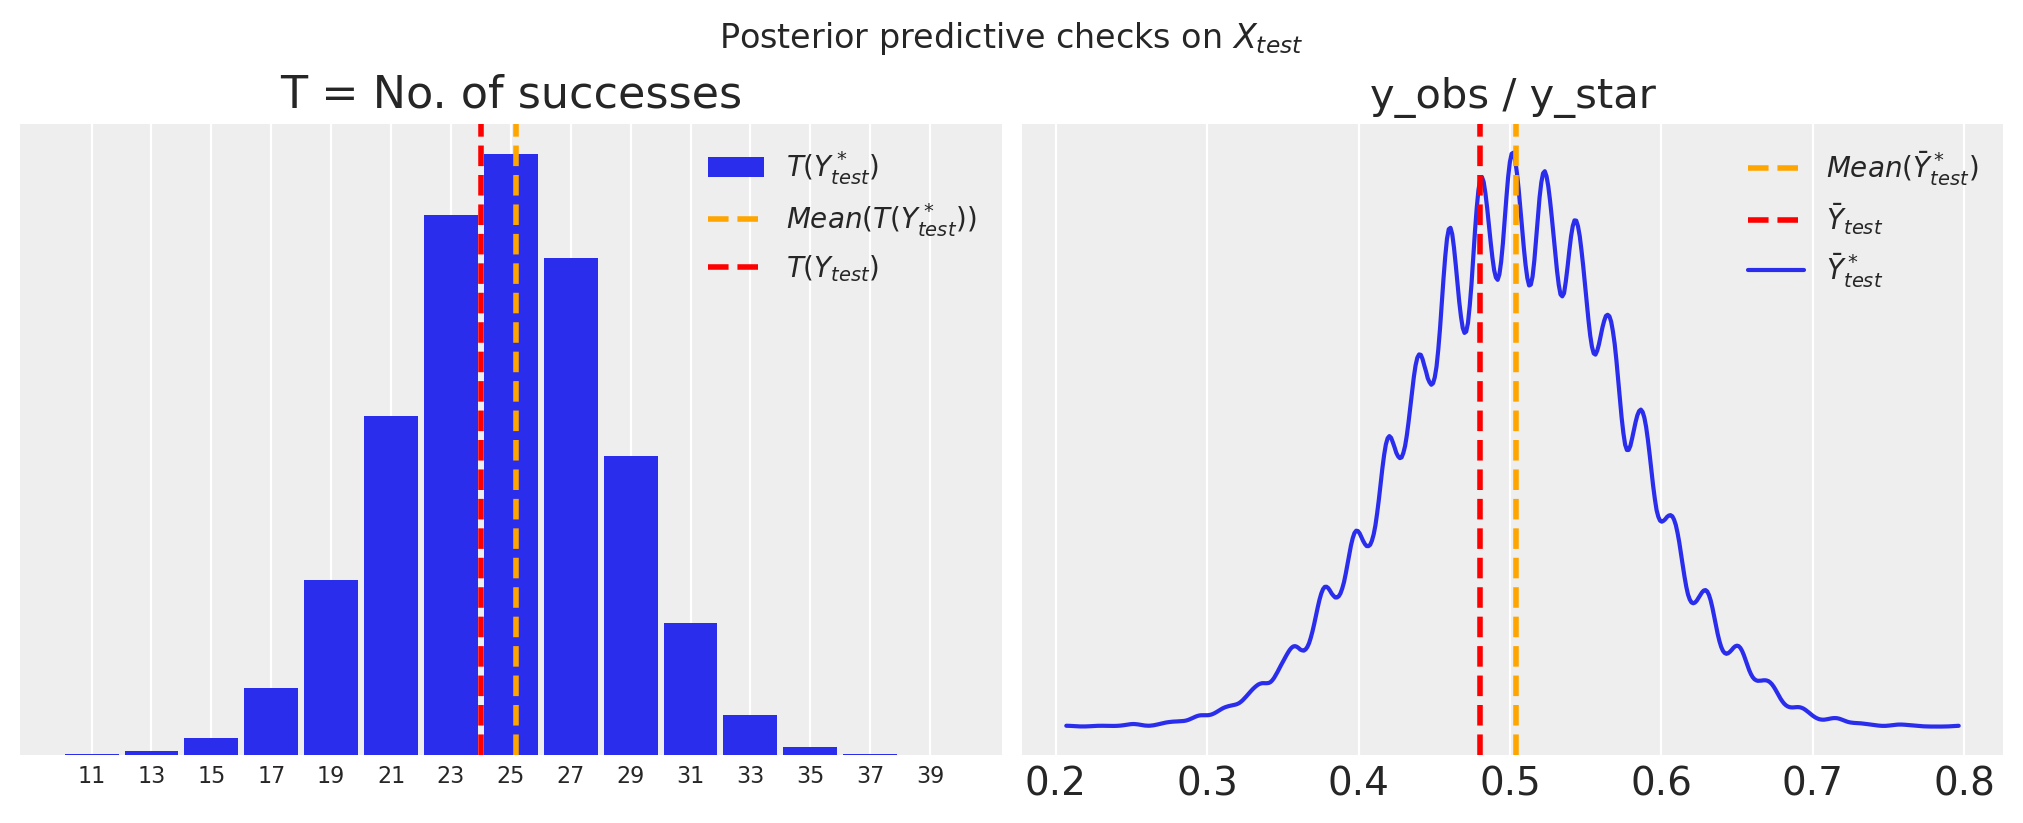

In [67]:
# -- Generate and plot posterior predictive samples from X_test

pp_test_p, pp_test_y = bayesian_model.generate_pp(
    idata_pymc, X_test, theta_space,
    rng=rng, kind='logistic', verbose=True)
idata_pp_test = pp_to_idata(
    [pp_test_p, pp_test_y], idata_pymc,
    ["p_star", "y_star"], y_obs=Y_test)

# Plot posterior predictive checks
plot_utils.plot_checks_logistic(idata_pp_test, test=True)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test_y, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

In [68]:
# -- Compute metrics using several point estimates

df_metrics_pymc = None

# Posterior mean estimates
strategies = [("posterior_mean", pp_test_p), ("posterior_vote", pp_test_y)]
for name, pp in strategies:
    Y_pred_pp = [apply_threshold(y)
                 for y in pp[:, ::thin_pp, :].mean(axis=(0, 1))]
    df_metrics_pymc = run_utils.logistic_regression_metrics(
        Y_test,
        Y_pred_pp,
        clf_pymc.n_components(name),
        "pymc_" + name,
        df=df_metrics_pymc,
        sort_by=sort_by
    )

# Point estimates
for pe in clf_pymc.default_point_estimates:
    Y_pred_pe = clf_pymc.predict(X_test, strategy=pe)
    df_metrics_pymc = run_utils.logistic_regression_metrics(
        Y_test,
        Y_pred_pe,
        clf_pymc.n_components(pe),
        "pymc_" + pe,
        df=df_metrics_pymc,
        sort_by=sort_by,
    )

df_metrics_pymc.style.hide(axis="index")

In [69]:
# -- Test variable selection procedure

df_metrics_pymc_var_sel = None

for pe in clf_pymc.default_point_estimates:
    X_red = clf_pymc.transform(X, pe=pe)
    X_test_red = clf_pymc.transform(X_test, pe=pe)

    df_metrics_pymc_var_sel = run_utils.multiple_logistic_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="pymc",
        pe=pe,
        df=df_metrics_pymc_var_sel,
        random_state=SEED
    )

df_metrics_pymc_var_sel.style.hide(axis="index")

### Save & Load

In [ ]:
# -- Save

_ = idata_pymc.to_netcdf("pymc-logistic.nc")

In [ ]:
# -- Load

idata_pymc = az.from_netcdf("pymc-logistic.nc")

## Notebook metadata

In [70]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Mon Sep 05 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

emcee     : 3.1.2
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]
autopep8  : 1.5.4
arviz     : 0.12.1
skfda     : 0.0
numpy     : 1.22.4
pymc      : 4.0.1
pandas    : 1.4.2
matplotlib: 3.5.2
scipy     : 1.8.1
json      : 2.0.9

Watermark: 2.3.1

